# Exploring Dandiset 000690: Allen Institute Openscope - Vision2Hippocampus project

> **Note**: This notebook was AI-generated and has not been fully verified. Please be cautious when interpreting the code or results presented here. Always validate important findings with additional analyses.

## 1. Introduction

This notebook explores data from the Allen Institute Openscope Vision2Hippocampus project, available as [Dandiset 000690 version 0.250326.0015](https://dandiarchive.org/dandiset/000690/0.250326.0015). This project investigates how visual representations evolve from the thalamus through visual cortical areas to hippocampus, studying the neural basis of how concrete visual stimuli are transformed into abstract concepts.

The project addresses a key question: how does the representation of simple visual stimuli evolve as information flows through the visual pathway to higher-order brain regions like the hippocampus? The data includes recordings from the lateral geniculate nucleus of the thalamus (LGN), primary visual cortex (V1), higher-order visual areas, and hippocampal regions.

### What we'll cover in this notebook:

1. **Overview of the Dandiset structure and content**
2. **Visual stimuli used in the experiment**
3. **Neural recording methods and electrode placements**
4. **Basic analysis of neural responses to different stimulus types**
5. **Example analyses for investigating visual processing**

## 2. Required Packages

In [1]:
# Import necessary libraries
import pynwb
import h5py
import remfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from itertools import islice
from dandi.dandiapi import DandiAPIClient
import os
from tqdm.notebook import tqdm  # For progress bars
import warnings
from functools import lru_cache  # For caching

# Set plot style
sns.set_theme()

# Set default figure size for better readability
plt.rcParams['figure.figsize'] = [12, 8]

# Standardize colors for brain regions for consistency
region_colors = {
    'TH': '#e41a1c',     # Thalamus - red
    'VPM': '#ff7f00',    # Ventral posteromedial nucleus - orange
    'LP': '#ffff33',     # Lateral posterior nucleus - yellow
    'VISli2/3': '#a65628',  # Visual cortex L2/3 - brown
    'VISli5': '#4daf4a',    # Visual cortex L5 - green
    'VISli4': '#a6d854',    # Visual cortex L4 - light green
    'RSPagl5': '#377eb8',   # Retrosplenial cortex - blue
    'CA1': '#984ea3',       # Hippocampus CA1 - purple
    'SUB': '#f781bf',       # Subiculum - pink
    'DG-sg': '#e7298a',     # Dentate gyrus - magenta
    'DG-mo': '#7570b3',     # Dentate gyrus - lavender
    'HPF': '#1b9e77',       # Hippocampal formation - teal
}

# Create a directory for caching NWB data
os.makedirs('cache', exist_ok=True)

## 3. Loading the Dandiset

We'll first connect to the DANDI archive and load basic information about the Dandiset. The DANDI archive is a platform for publishing, sharing, and processing neurophysiology data.

In [2]:
# Connect to DANDI archive
client = DandiAPIClient()
dandiset = client.get_dandiset("000690", "0.250326.0015")

# Print basic information about the Dandiset
metadata = dandiset.get_raw_metadata()
print(f"Dandiset name: {metadata['name']}")
print(f"Dandiset URL: {metadata['url']}")
print(f"Description: {metadata['description'][:500]}...") # Show first part of description

# List some assets in the Dandiset
print("\nExploring Dandiset assets...")
assets = dandiset.get_assets()
print("First 5 assets:")
for asset in islice(assets, 5):
    print(f"- {asset.path} (ID: {asset.identifier}, Size: {asset.size/1e9:.2f} GB)")

Dandiset name: Allen Institute Openscope - Vision2Hippocampus project
Dandiset URL: https://dandiarchive.org/dandiset/000690/0.250326.0015
Description: Extensive research shows that visual cortical neurons respond to specific stimuli, e.g. the primary visual cortical neurons respond to bars of light with specific orientation. In contrast, the hippocampal neurons are thought to encode not specific stimuli but instead represent abstract concepts such as space, time and events. How is this abstraction computed in the mouse brain? Specifically, how does the representation of simple visual stimuli evolve from the thalamus, which is a synapse away fr...

Exploring Dandiset assets...
First 5 assets:
- sub-692077/sub-692077_ses-1300222049_probe-4_ecephys.nwb (ID: b0ea16d5-42eb-4b56-87cc-7d7b7efab4db, Size: 1.68 GB)
- sub-692077/sub-692077_ses-1300222049_probe-3_ecephys.nwb (ID: e0ad1921-75f1-43ed-aa86-8e1a45a9f49d, Size: 1.78 GB)
- sub-692077/sub-692077_ses-1300222049_probe-2_ecephys.nwb (ID: 

## 4. Data Structure and Organization

The Dandiset contains multiple NWB (Neurodata Without Borders) files for different experimental subjects. For each subject, there are typically:

1. A main NWB file with session-level data
2. An image NWB file with visual stimuli data
3. Multiple probe-specific NWB files with electrophysiology data from different brain regions

NWB is a standardized neurophysiology data format that facilitates data sharing and reproducible research.

### Brain Region Abbreviations

This dataset contains recordings from many brain regions. Here's a guide to the abbreviations:

| Abbreviation | Full Name | Function |
|--------------|-----------|----------|
| TH | Thalamus | Relay station for sensory and motor signals |
| VPM | Ventral Posteromedial Nucleus | Processes somatosensory information |
| LP | Lateral Posterior Nucleus | Higher-order visual thalamic nucleus |
| VISli | Lateral Visual Cortex (with layer numbers) | Visual cortical processing |
| RSPagl | Retrosplenial Cortex, Lateral Agranular Part | Involved in navigation and memory |
| CA1 | Cornu Ammonis 1 | Major output region of hippocampus |
| SUB | Subiculum | Output structure of the hippocampus |
| DG-sg | Dentate Gyrus, Granule Cell Layer | Input region of hippocampus |
| DG-mo | Dentate Gyrus, Molecular Layer | Input region of hippocampus |
| HPF | Hippocampal Formation | Memory formation and spatial navigation |

The "root" designation often indicates recording channels outside specific annotated brain regions.

In [3]:
# Define URLs for the files we'll examine
main_file_url = "https://api.dandiarchive.org/api/assets/fbcd4fe5-7107-41b2-b154-b67f783f23dc/download/"
image_file_url = "https://api.dandiarchive.org/api/assets/cbc64387-19b9-494a-a8fa-04d3207f7ffb/download/"
probe_file_url = "https://api.dandiarchive.org/api/assets/ba8760f9-91fe-4c1c-97e6-590bed6a783b/download/"

# Function to create a cached filename for an NWB file
def get_cache_filename(url):
    """Create a cache filename based on the URL"""
    import hashlib
    # Create a hash of the URL to use as filename
    url_hash = hashlib.md5(url.encode()).hexdigest()
    return f"cache/nwb_file_{url_hash}.pkl"

# Function to load an NWB file with caching
@lru_cache(maxsize=5)  # Cache the last 5 loaded files
def load_nwb(url, use_cache=True):
    """
    Load an NWB file with caching support
    
    Parameters:
    -----------
    url : str
        URL of the NWB file
    use_cache : bool
        Whether to use cached file if available
        
    Returns:
    --------
    nwb : pynwb.NWBFile
        Loaded NWB file
    """
    cache_file = get_cache_filename(url)
    
    if use_cache and os.path.exists(cache_file):
        try:
            print(f"Loading cached NWB file from {cache_file}")
            import pickle
            with open(cache_file, 'rb') as f:
                return pickle.load(f)
        except Exception as e:
            print(f"Error loading cache file: {e}")
            print("Loading from URL instead")
    
    try:
        print(f"Loading NWB file from URL: {url}")
        print("This may take a few minutes for large files...")
        
        remote_file = remfile.File(url)
        h5_file = h5py.File(remote_file)
        io = pynwb.NWBHDF5IO(file=h5_file)
        nwb = io.read()
        
        if use_cache:
            try:
                print(f"Saving to cache: {cache_file}")
                import pickle
                with open(cache_file, 'wb') as f:
                    pickle.dump(nwb, f)
            except Exception as e:
                print(f"Error saving to cache: {e}")
        
        return nwb
    except Exception as e:
        print(f"Error loading NWB file: {e}")
        raise

# Load the main NWB file
try:
    print("Loading main NWB file...")
    main_nwb = load_nwb(main_file_url)

    # Display basic session information
    print("\nSession Information:")
    print(f"Session ID: {main_nwb.session_id}")
    print(f"Subject ID: {main_nwb.subject.subject_id}")
    print(f"Session date: {main_nwb.session_start_time}")
    print(f"Subject age: {main_nwb.subject.age}")
    print(f"Subject sex: {main_nwb.subject.sex}")
    print(f"Subject species: {main_nwb.subject.species}")
    print(f"Subject strain: {main_nwb.subject.strain}")
    
except Exception as e:
    print(f"Error loading or processing main NWB file: {e}")

Loading main NWB file...
Loading NWB file from URL: https://api.dandiarchive.org/api/assets/fbcd4fe5-7107-41b2-b154-b67f783f23dc/download/
This may take a few minutes for large files...


/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.6.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.3.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Saving to cache: cache/nwb_file_96bfa015d30588de1b7cad20042e6a31.pkl
Error saving to cache: Can't pickle <class 'abc.EllipseEyeTracking'>: attribute lookup EllipseEyeTracking on abc failed

Session Information:
Session ID: 1298465622
Subject ID: 692072
Session date: 2023-09-21 00:00:00-07:00
Subject age: P82D
Subject sex: M
Subject species: Mus musculus
Subject strain: Transgenic


## 5. Electrode Placement and Brain Regions

The recordings were made using Neuropixels 1.0 probes positioned across multiple brain regions. These probes have 384 recording sites along a linear shank, allowing for simultaneous recording from multiple brain regions along the probe trajectory. Let's examine the probe configurations and which brain regions were targeted.

Number of electrodes per probe:
group_name
probeA    384
probeB    384
probeE    384
probeF    384
dtype: int64

Top 10 brain regions by electrode count:
location
root     296
CP       198
CA1       92
HPF       67
LP        67
RT        62
SUB       59
MOp6a     53
DG-mo     47
VL        47
Name: count, dtype: int64


/tmp/ipykernel_33179/2193461126.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=region_counts_plot.values, y=region_counts_plot.index, palette=colors)


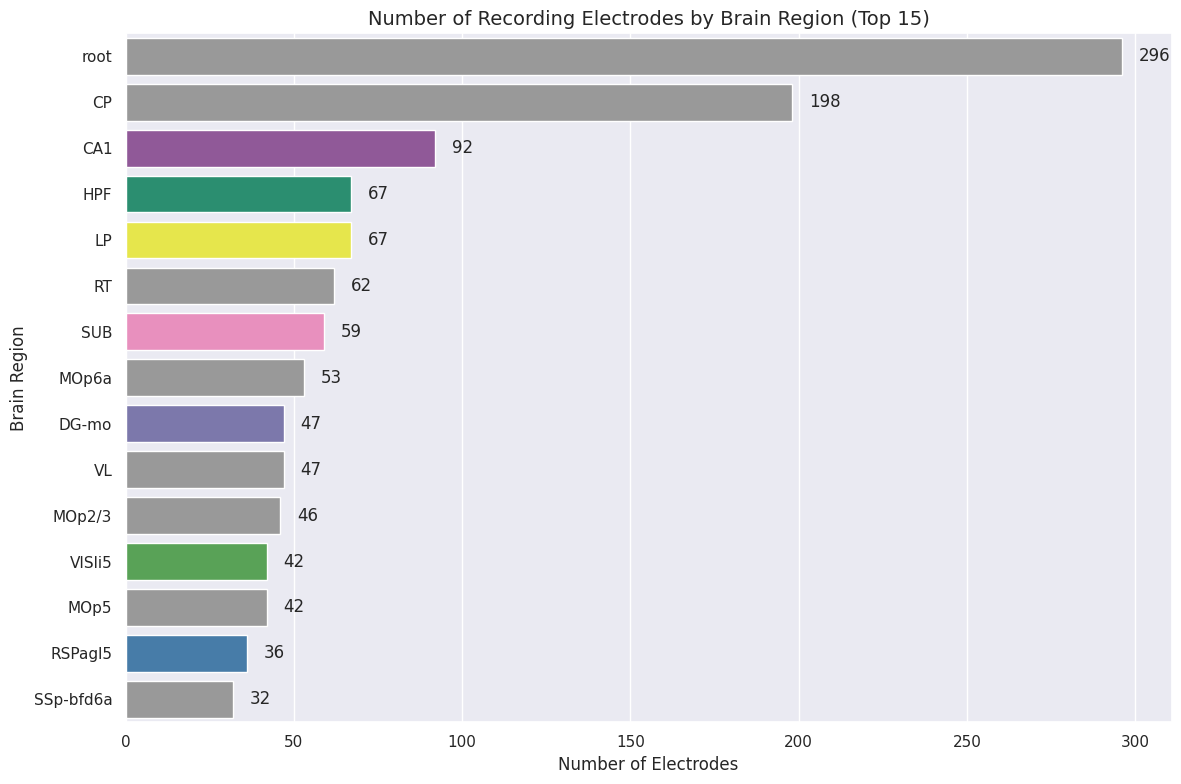

In [4]:
# Get electrode table as dataframe
try:
    electrodes_df = main_nwb.electrodes.to_dataframe()

    # Summary of probes and brain regions
    probe_groups = electrodes_df.groupby('group_name').size()
    print("Number of electrodes per probe:")
    print(probe_groups)

    # Count electrodes per brain region
    region_counts = electrodes_df['location'].value_counts()
    print("\nTop 10 brain regions by electrode count:")
    print(region_counts.head(10))

    # Visualize electrode counts by region
    plt.figure(figsize=(12, 8))
    region_counts_plot = region_counts.iloc[:15]  # Top 15 regions
    
    # Use consistent colors where possible
    colors = [region_colors.get(region, '#999999') for region in region_counts_plot.index]
    
    ax = sns.barplot(x=region_counts_plot.values, y=region_counts_plot.index, palette=colors)
    plt.xlabel('Number of Electrodes', fontsize=12)
    plt.ylabel('Brain Region', fontsize=12)
    plt.title('Number of Recording Electrodes by Brain Region (Top 15)', fontsize=14)
    
    # Add value labels to bars
    for i, v in enumerate(region_counts_plot.values):
        ax.text(v + 5, i, str(v), va='center')
        
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error processing electrode data: {e}")

### 3D Visualization of Electrode Locations

To better understand the spatial arrangement of recording sites, we can visualize the electrode locations in 3D space. This helps us see how the probes were positioned in the brain.

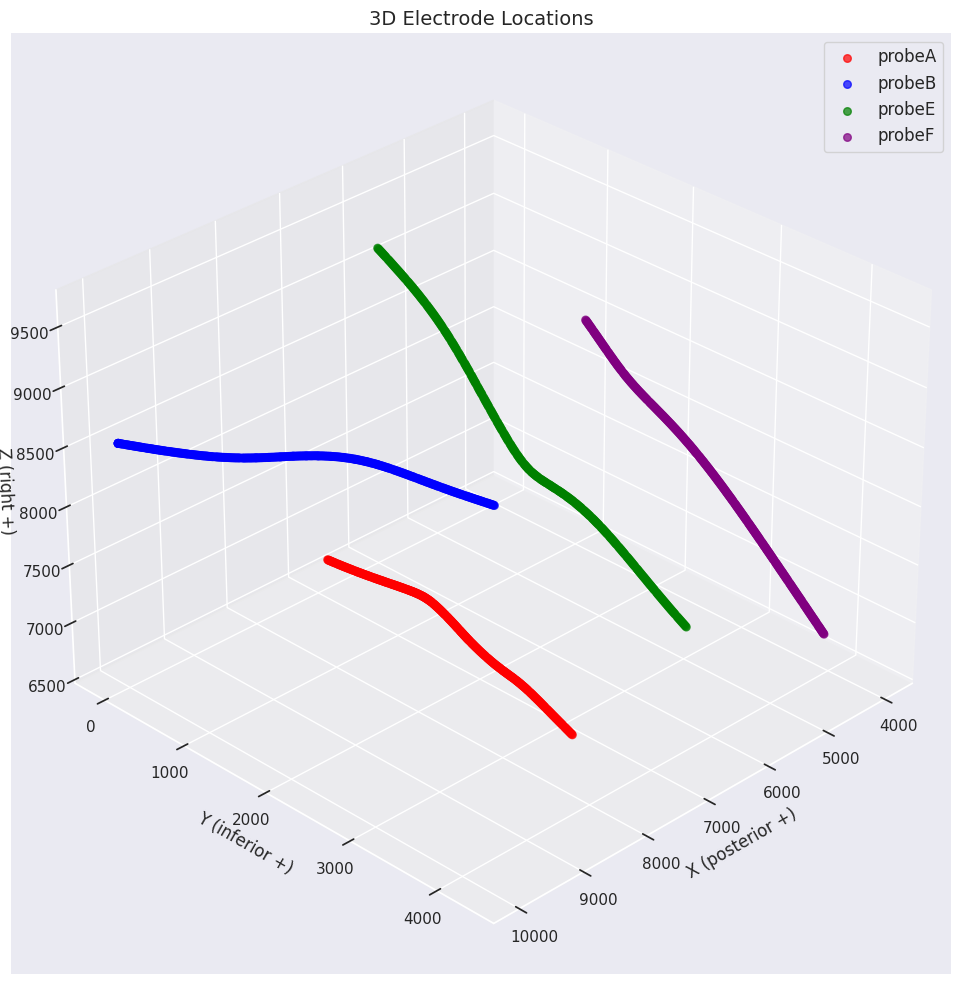

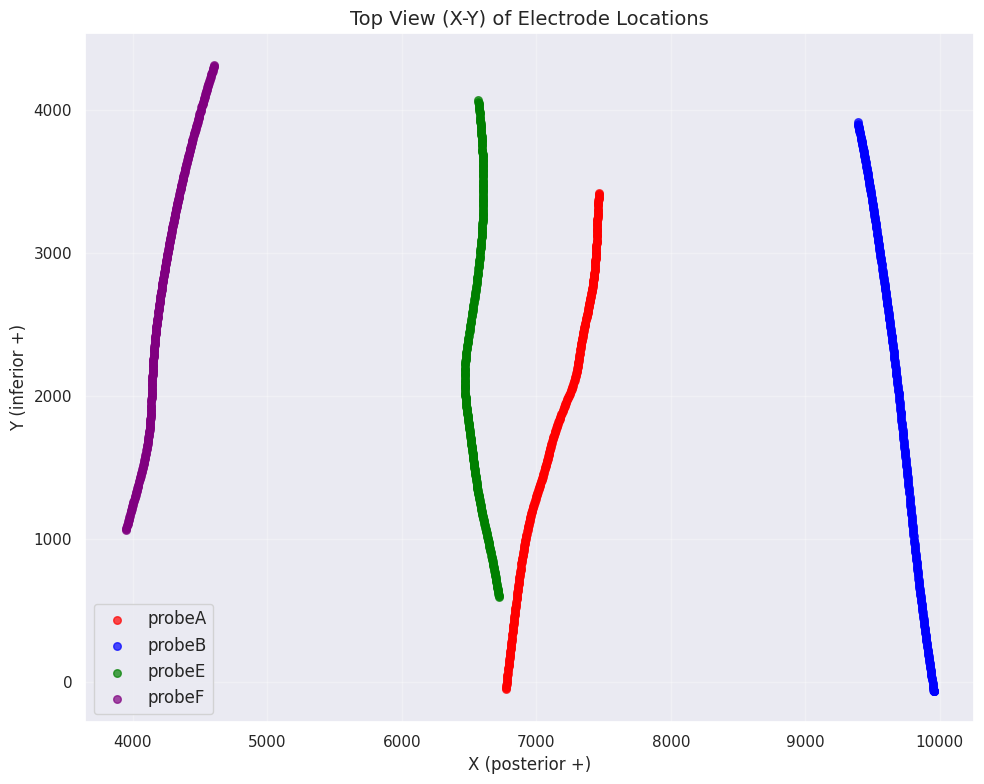

In [5]:
# Create a 3D plot of electrode positions
from mpl_toolkits.mplot3d import Axes3D

try:
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Dictionary to map group names to colors
    probe_colors = {'probeA': 'red', 'probeB': 'blue', 'probeE': 'green', 'probeF': 'purple'}

    for group_name in electrodes_df['group_name'].unique():
        group_df = electrodes_df[electrodes_df['group_name'] == group_name]
        ax.scatter(
            group_df['x'], 
            group_df['y'], 
            group_df['z'], 
            c=probe_colors.get(group_name, 'black'),
            label=group_name,
            alpha=0.7,
            s=30  # Increase point size for visibility
        )

    ax.set_xlabel('X (posterior +)', fontsize=12)
    ax.set_ylabel('Y (inferior +)', fontsize=12)
    ax.set_zlabel('Z (right +)', fontsize=12)
    ax.legend(fontsize=12)
    ax.set_title('3D Electrode Locations', fontsize=14)
    
    # Add grid for better depth perception
    ax.grid(True, alpha=0.3)
    
    # Improve 3D perspective
    ax.view_init(elev=30, azim=45)
    
    plt.tight_layout()
    plt.show()
    
    # Show a 2D top view for clarity
    fig, ax = plt.subplots(figsize=(10, 8))
    
    for group_name in electrodes_df['group_name'].unique():
        group_df = electrodes_df[electrodes_df['group_name'] == group_name]
        ax.scatter(
            group_df['x'], 
            group_df['y'],
            c=probe_colors.get(group_name, 'black'),
            label=group_name,
            alpha=0.7,
            s=30
        )
    
    ax.set_xlabel('X (posterior +)', fontsize=12)
    ax.set_ylabel('Y (inferior +)', fontsize=12)
    ax.set_title('Top View (X-Y) of Electrode Locations', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error visualizing electrode locations: {e}")

### Understanding the Probe Arrangement

The probes were positioned to record from regions along the visual pathway from thalamus to hippocampus:

- **Probe A**: Targeted visual thalamic regions like LGN (Lateral Geniculate Nucleus) and LP (Lateral Posterior nucleus)
- **Probe B**: Positioned in visual cortical areas including primary and higher visual areas
- **Probe E**: Recorded from hippocampal formation including CA1 and dentate gyrus (DG)
- **Probe F**: Captured additional cortical regions including retrosplenial cortex

This arrangement allows for examining how visual information is transformed as it progresses through the visual pathway. The Neuropixels probes enable recording from multiple regions along their insertion trajectory, capturing activity across different stages of visual processing simultaneously.

## 6. Visual Stimuli Types

The experiment used several types of visual stimuli to study how the brain processes different visual inputs. Let's load the image file containing the stimuli and examine what was presented to the mice during the recordings.

In [6]:
# Load the image NWB file containing stimuli
try:
    print("Loading image file...")
    image_nwb = load_nwb(image_file_url)

    # Get stimulus template information
    stim_templates = image_nwb.stimulus_template

    # Print available stimulus templates
    print("Available stimulus templates:")
    for i, name in enumerate(list(stim_templates.keys())[:10]):  # Show first 10 for brevity
        stim = stim_templates[name]
        if hasattr(stim, 'data'):
            shape = stim.data.shape
            print(f"- {name}: shape {shape}, rate {stim.rate} Hz")
            
    # Get stimulus presentation intervals
    intervals = image_nwb.intervals

    # Count presentation intervals by stimulus type
    presentation_counts = {}
    for name in intervals.keys():
        if "_presentations" in name:
            try:
                interval = intervals[name]
                count = len(interval.start_time[:])
                presentation_counts[name] = count
            except Exception as e:
                print(f"Error processing interval {name}: {e}")

    # Show count of a few stimulus presentations
    print("\nNumber of stimulus presentations for selected stimuli:")
    selected_stimuli = ['SAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations',
                       'Disk_Wd15_Vel2_Bndry1_Cntst0_loop_presentations',
                       'natmovie_EagleSwooping1_540x960Full_584x460Active_presentations',
                       'spontaneous_presentations']
                       
    for name in selected_stimuli:
        if name in presentation_counts:
            print(f"- {name}: {presentation_counts[name]} presentations")
    
except Exception as e:
    print(f"Error loading or processing image NWB file: {e}")

Loading image file...
Loading NWB file from URL: https://api.dandiarchive.org/api/assets/cbc64387-19b9-494a-a8fa-04d3207f7ffb/download/
This may take a few minutes for large files...


Saving to cache: cache/nwb_file_17aa92eefd8eaf6ded0e7631bad75ee6.pkl
Error saving to cache: Can't pickle <class 'abc.EllipseEyeTracking'>: attribute lookup EllipseEyeTracking on abc failed
Available stimulus templates:
- Disco2SAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations: shape (960, 540, 240, 3), rate 60.0 Hz
- Disk_Wd15_Vel2_Bndry1_Cntst0_loop_presentations: shape (960, 540, 240), rate 60.0 Hz
- GreenSAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations: shape (960, 540, 240, 3), rate 60.0 Hz
- Ring_Wd15_Vel2_Bndry1_Cntst0_loop_presentations: shape (960, 540, 240), rate 60.0 Hz
- SAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations: shape (960, 540, 240), rate 60.0 Hz
- SAC_Wd15_Vel2_Bndry1_Cntst1_loop_presentations: shape (960, 540, 240), rate 60.0 Hz
- SAC_Wd15_Vel2_Bndry2_Cntst0_loop_presentations: shape (960, 540, 284), rate 60.0 Hz
- SAC_Wd15_Vel2_Bndry2_Cntst0_oneway_presentations: shape (960, 540, 142), rate 60.0 Hz
- SAC_Wd15_Vel2_Bndry3_Cntst0_loop_presentations: shape (960, 540, 372),


Number of stimulus presentations for selected stimuli:
- SAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations: 57600 presentations
- Disk_Wd15_Vel2_Bndry1_Cntst0_loop_presentations: 28800 presentations
- natmovie_EagleSwooping1_540x960Full_584x460Active_presentations: 28800 presentations
- spontaneous_presentations: 21 presentations


### Visualizing the Stimulus Types

Let's visualize examples of the different types of visual stimuli used in the experiment. This will help us understand what the mice were seeing during the recordings.

Simple Oriented Bar Stimulus:


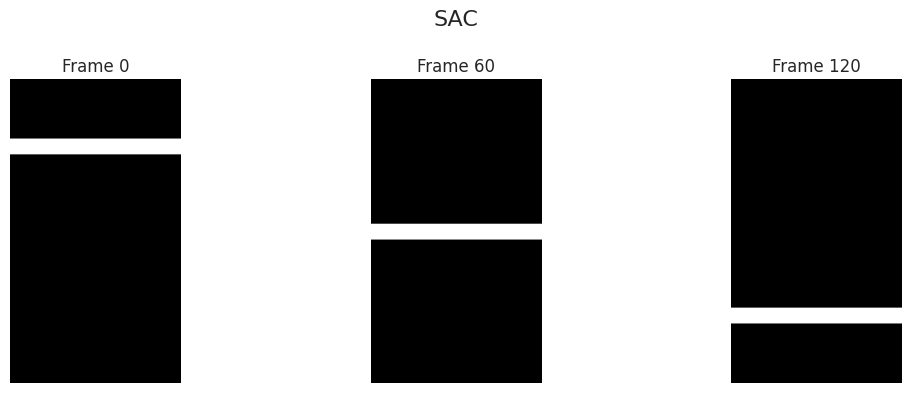


Complex Shape Stimulus (Disk):


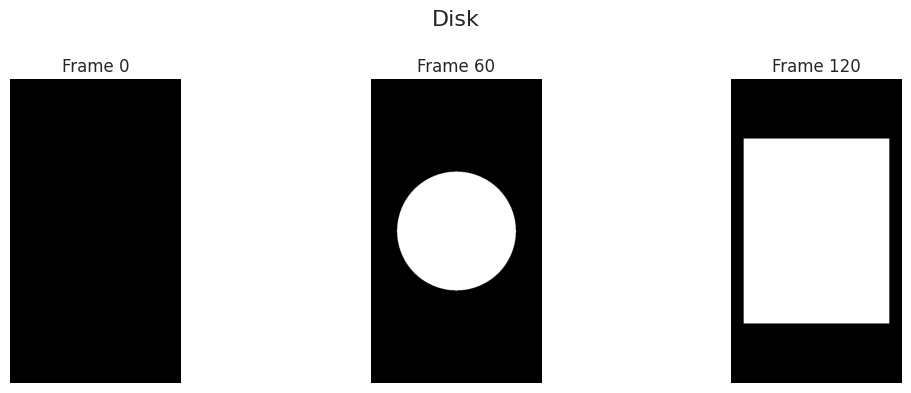


Natural Movie (Eagle):


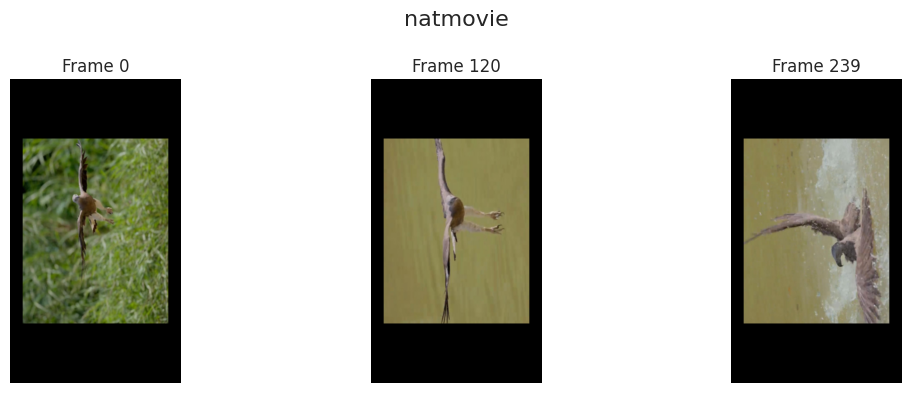

In [7]:
# Function to display a stimulus frame
def display_stimulus(stim_name, frame_idx=0):
    """
    Display a frame from a stimulus
    
    Parameters:
    -----------
    stim_name : str
        Name of the stimulus template
    frame_idx : int
        Index of the frame to display
        
    Returns:
    --------
    None
    """
    if stim_name not in stim_templates:
        print(f"Stimulus {stim_name} not found")
        return
        
    stim = stim_templates[stim_name]
    
    if not hasattr(stim, 'data'):
        print(f"No data attribute in stimulus {stim_name}")
        return
        
    try:
        # Get shape information
        shape = stim.data.shape
        
        # Ensure frame_idx is within range
        if len(shape) >= 3:
            max_frames = shape[2] if len(shape) == 3 else shape[2]
            if frame_idx >= max_frames:
                frame_idx = max_frames - 1
                print(f"Adjusted frame index to {frame_idx}")
                
            # Display the frame
            plt.figure(figsize=(8, 8))
            
            if len(shape) == 3:  # Grayscale
                plt.imshow(stim.data[:, :, frame_idx], cmap='gray')
            else:  # Color (assuming shape is h, w, frames, channels)
                plt.imshow(stim.data[:, :, frame_idx, :])
                
            plt.title(f"{stim_name.split('_')[0]} - Frame {frame_idx}")
            plt.axis('off')
            plt.tight_layout()
            plt.show()
            
            return True
        else:
            print(f"Unexpected shape for {stim_name}: {shape}")
            return False
    
    except Exception as e:
        print(f"Error displaying stimulus {stim_name}: {e}")
        return False

# Function to display multiple frames from a stimulus
def display_stimulus_sequence(stim_name, frame_indices=None):
    """
    Display multiple frames from a stimulus
    
    Parameters:
    -----------
    stim_name : str
        Name of the stimulus template
    frame_indices : list of int
        Indices of frames to display
        
    Returns:
    --------
    None
    """
    if stim_name not in stim_templates:
        print(f"Stimulus {stim_name} not found")
        return
        
    stim = stim_templates[stim_name]
    
    if not hasattr(stim, 'data'):
        print(f"No data attribute in stimulus {stim_name}")
        return
        
    try:
        # Get shape information
        shape = stim.data.shape
        
        # Set default frame indices if not provided
        if frame_indices is None:
            if len(shape) >= 3:
                max_frames = shape[2] if len(shape) == 3 else shape[2]
                frame_indices = np.linspace(0, max_frames-1, 3, dtype=int)
            else:
                print(f"Unexpected shape for {stim_name}: {shape}")
                return
                
        # Create a figure with subplots for each frame
        fig, axes = plt.subplots(1, len(frame_indices), figsize=(4*len(frame_indices), 4))
        
        # Handle case with only one frame
        if len(frame_indices) == 1:
            axes = [axes]
            
        for i, frame_idx in enumerate(frame_indices):
            if frame_idx >= shape[2]:
                print(f"Frame index {frame_idx} out of range")
                continue
                
            ax = axes[i]
            
            if len(shape) == 3:  # Grayscale
                ax.imshow(stim.data[:, :, frame_idx], cmap='gray')
            else:  # Color (assuming shape is h, w, frames, channels)
                ax.imshow(stim.data[:, :, frame_idx, :])
                
            ax.set_title(f"Frame {frame_idx}")
            ax.axis('off')
        
        plt.suptitle(f"{stim_name.split('_')[0]}", fontsize=16)
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error displaying stimulus sequence {stim_name}: {e}")

# Display examples of different stimulus types
try:
    # Simple oriented stimulus
    print("Simple Oriented Bar Stimulus:")
    display_stimulus_sequence('SAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations', [0, 60, 120])
    
    print("\nComplex Shape Stimulus (Disk):")
    display_stimulus_sequence('Disk_Wd15_Vel2_Bndry1_Cntst0_loop_presentations', [0, 60, 120])
    
    print("\nNatural Movie (Eagle):")
    display_stimulus_sequence('natmovie_EagleSwooping1_540x960Full_584x460Active_presentations', [0, 120, 239])
    
except Exception as e:
    print(f"Error displaying stimuli: {e}")

### Simple Oriented Stimuli

The simple oriented stimuli consisted of moving bars of light. The naming convention indicates their parameters:

- **SAC**: Standard bar stimulus
- **Wd**: Width (e.g., Wd15 = 15 degrees, Wd45 = 45 degrees)
- **Vel**: Velocity (e.g., Vel2 = 2 seconds to cross screen, Vel8 = 8 seconds)
- **Bndry**: Boundary condition (how stimulus interacts with screen edge)
- **Cntst**: Contrast (e.g., Cntst0 = white bar on black, Cntst1 = black bar on white)

The experiment systematically varied these parameters to study how the visual system processes basic features like orientation, size, and motion.

### Natural Movie Stimuli

The natural movie stimuli included clips of different animals:

- Eagles swooping (natmovie_EagleSwooping1, natmovie_EagleSwooping2)
- Snake on a road (natmovie_SnakeOnARoad)
- Crickets on a rock (natmovie_CricketsOnARock)
- Squirrels and mice (natmovie_Squirreland3Mice)

These natural stimuli test how the visual system processes complex, ethologically relevant visual information. Natural scenes contain rich statistical regularities that the visual system has evolved to process efficiently. By comparing neural responses to artificial and natural stimuli, researchers can investigate how the brain extracts meaningful information from complex visual environments.

## 7. Neural Responses

Now let's examine the neural activity recorded during the experiment. We'll analyze how neurons in different brain regions respond to various stimuli.

Total number of units: 2764
Unit quality counts: {'good': 2311, 'noise': 453}


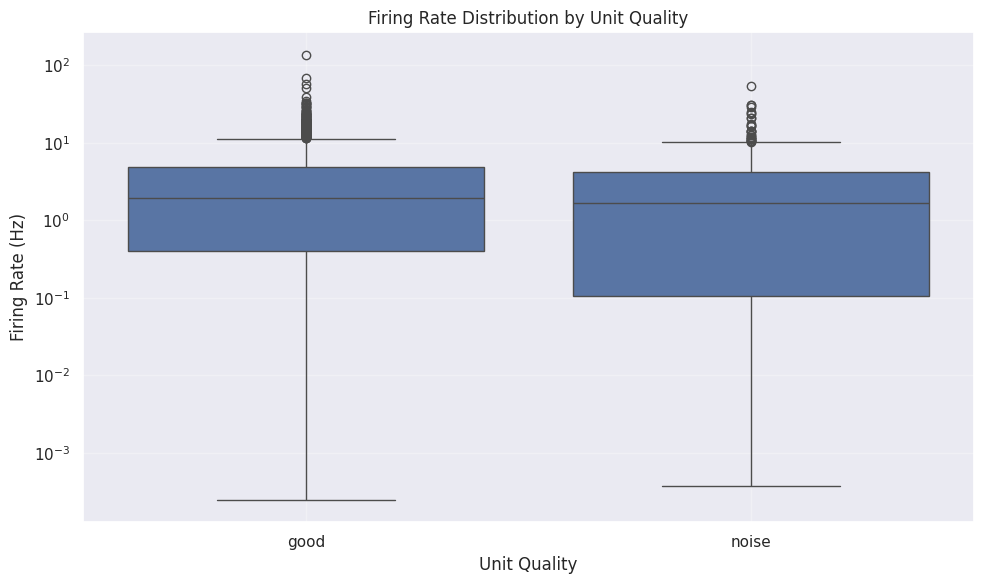

/tmp/ipykernel_33179/3632106959.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Number of Units', y='Brain Region', data=top_regions, palette=colors)


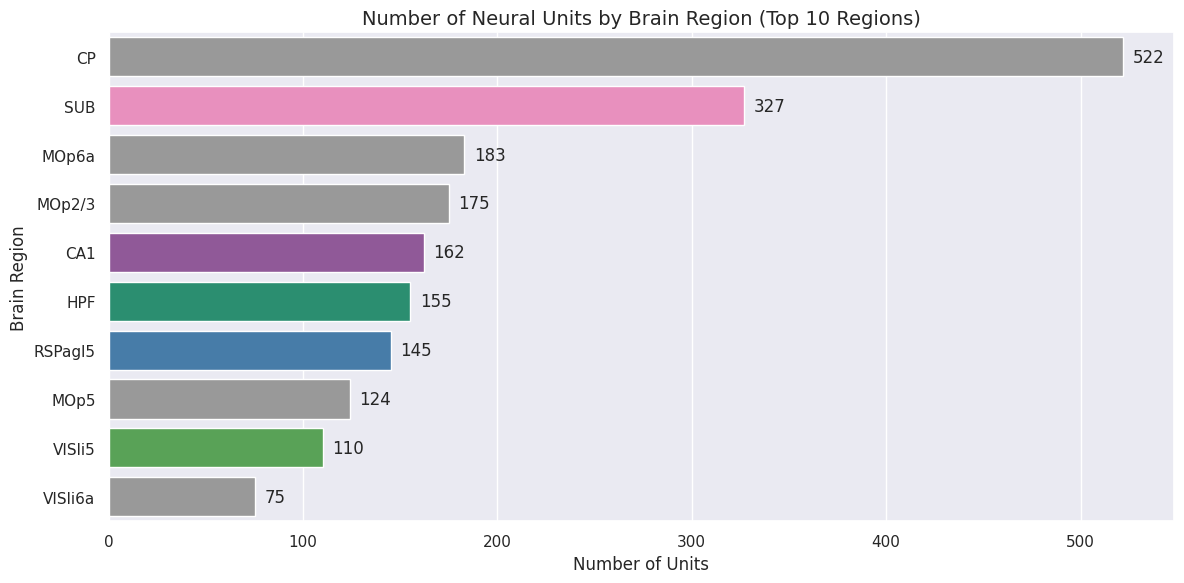

/tmp/ipykernel_33179/3632106959.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Mean Firing Rate (Hz)', y='Brain Region', data=top_regions_rates, palette=colors)


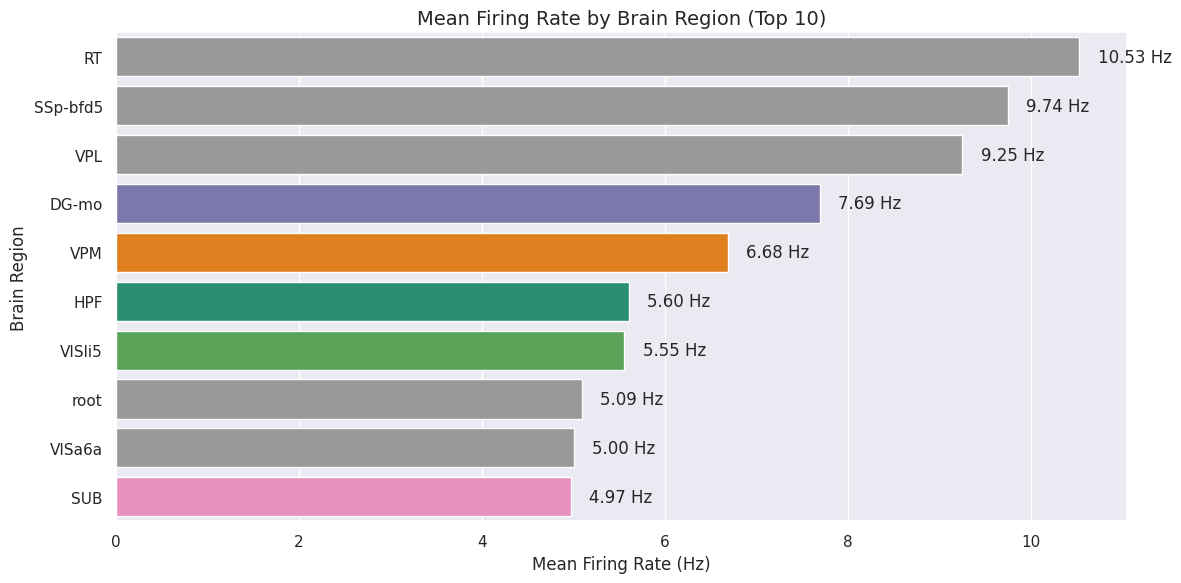

In [8]:
# Get unit information
try:
    units_df = main_nwb.units.to_dataframe()
    print(f"Total number of units: {len(units_df)}")
    
    if 'quality' in units_df.columns:
        quality_counts = units_df['quality'].value_counts()
        print(f"Unit quality counts: {quality_counts.to_dict()}")
        
        # Show firing rate distribution by quality
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='quality', y='firing_rate', data=units_df)
        plt.title('Firing Rate Distribution by Unit Quality')
        plt.xlabel('Unit Quality')
        plt.ylabel('Firing Rate (Hz)')
        plt.yscale('log')  # Log scale for better visualization
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    # Map electrode IDs to brain regions
    electrode_df = main_nwb.electrodes.to_dataframe()
    electrode_to_location = {i: loc for i, loc in zip(electrode_df.index, electrode_df['location'])}

    # Get peak channel for each unit (if available)
    unit_locations = {}
    if 'peak_channel_id' in units_df.columns:
        for unit_id, peak_channel in zip(units_df.index, units_df['peak_channel_id']):
            if peak_channel in electrode_to_location:
                unit_locations[unit_id] = electrode_to_location[peak_channel]
            else:
                unit_locations[unit_id] = "unknown"
                
    # Count units per brain region
    units_per_region = {}
    for unit_id, location in unit_locations.items():
        if location in units_per_region:
            units_per_region[location] += 1
        else:
            units_per_region[location] = 1

    # Display top regions by unit count
    units_per_region_df = pd.DataFrame(list(units_per_region.items()), 
                                     columns=['Brain Region', 'Number of Units'])
    top_regions = units_per_region_df.sort_values('Number of Units', ascending=False).head(10)

    plt.figure(figsize=(12, 6))
    
    # Use consistent colors where possible
    colors = [region_colors.get(region, '#999999') for region in top_regions['Brain Region']]
    
    ax = sns.barplot(x='Number of Units', y='Brain Region', data=top_regions, palette=colors)
    plt.title('Number of Neural Units by Brain Region (Top 10 Regions)', fontsize=14)
    
    # Add value labels to bars
    for i, v in enumerate(top_regions['Number of Units']):
        ax.text(v + 5, i, str(v), va='center')
        
    plt.tight_layout()
    plt.show()
    
    # Calculate average firing rate by brain region
    if 'firing_rate' in units_df.columns:
        region_firing_rates = {}
        
        for unit_id, location in unit_locations.items():
            if location not in region_firing_rates:
                region_firing_rates[location] = []
                
            rate = units_df.loc[unit_id, 'firing_rate']
            if not np.isnan(rate):
                region_firing_rates[location].append(rate)
        
        # Calculate mean firing rates
        region_mean_rates = {region: np.mean(rates) for region, rates in region_firing_rates.items() 
                           if rates and len(rates) >= 5}  # At least 5 units
        
        # Convert to DataFrame for plotting
        region_rates_df = pd.DataFrame(list(region_mean_rates.items()), 
                                     columns=['Brain Region', 'Mean Firing Rate (Hz)'])
        top_regions_rates = region_rates_df.sort_values('Mean Firing Rate (Hz)', ascending=False).head(10)
        
        plt.figure(figsize=(12, 6))
        
        # Use consistent colors where possible
        colors = [region_colors.get(region, '#999999') for region in top_regions_rates['Brain Region']]
        
        ax = sns.barplot(x='Mean Firing Rate (Hz)', y='Brain Region', data=top_regions_rates, palette=colors)
        plt.title('Mean Firing Rate by Brain Region (Top 10)', fontsize=14)
        
        # Add value labels to bars
        for i, v in enumerate(top_regions_rates['Mean Firing Rate (Hz)']):
            ax.text(v + 0.2, i, f"{v:.2f} Hz", va='center')
            
        plt.tight_layout()
        plt.show()
        
except Exception as e:
    print(f"Error analyzing neural units: {e}")

### Analysis of Neural Responses to Visual Stimuli

Now let's analyze how neurons respond to different visual stimuli. We'll select a unit and examine its responses to simple oriented stimuli, complex shape stimuli, and natural movies. This will help us understand how the brain processes these different visual inputs.

In [9]:
# Function to analyze unit responses to stimuli
def analyze_unit_responses(unit_id, stimulus_intervals, window=[-0.5, 1.0], 
                          max_presentations=100, bin_count=50):
    """
    Analyze how a specific unit responds to given stimulus presentations
    
    Parameters:
    -----------
    unit_id : int
        ID of the unit to analyze
    stimulus_intervals : TimeIntervals
        Intervals of stimulus presentations
    window : list
        Time window around stimulus onset [start, end] in seconds
    max_presentations : int
        Maximum number of presentations to analyze
    bin_count : int
        Number of bins for the PSTH
    
    Returns:
    --------
    tuple
        (psth, raster) - peristimulus time histogram and spike raster
    """
    if unit_id not in units_df.index:
        print(f"Unit {unit_id} not found")
        return None, None
        
    unit_spike_times = units_df.loc[unit_id, 'spike_times']
    
    if len(unit_spike_times) == 0:
        print(f"Unit {unit_id} has no spike times")
        return None, None
    
    # Get stimulus onset times
    stim_onsets = stimulus_intervals.start_time[:]
    
    # Take at most max_presentations for efficiency
    if len(stim_onsets) > max_presentations:
        # Use a fixed random seed for reproducibility
        np.random.seed(42)
        indices = np.random.choice(len(stim_onsets), max_presentations, replace=False)
        stim_onsets = stim_onsets[indices]
    
    # Prepare binning for PSTH
    bin_edges = np.linspace(window[0], window[1], bin_count+1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    all_counts = []
    raster_data = []
    
    # Compute spike counts around each stimulus onset
    for onset in stim_onsets:
        # Find spikes in the window around this stimulus
        window_spikes = unit_spike_times[
            (unit_spike_times >= onset + window[0]) & 
            (unit_spike_times <= onset + window[1])
        ] - onset  # Align to stimulus onset
        
        # Store raster data
        raster_data.append(window_spikes)
        
        # Bin spikes for PSTH
        counts, _ = np.histogram(window_spikes, bins=bin_edges)
        all_counts.append(counts)
    
    # Average across trials
    mean_counts = np.mean(all_counts, axis=0)
    
    # Convert to firing rate (spikes/s)
    bin_width = bin_edges[1] - bin_edges[0]
    firing_rate = mean_counts / bin_width
    
    return (bin_centers, firing_rate), raster_data

Let's select a unit to analyze. We'll find a unit from the thalamus (TH) to explore how early visual processing occurs.

Selected unit 26 from TH
  Firing rate: 2.79 Hz
Selected unit 1201 from VISli5
  Firing rate: 29.33 Hz
Selected unit 211 from CA1
  Firing rate: 2.23 Hz

Analyzing responses of unit 26 (TH) to different stimuli
  Analyzing responses to SAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations


  Analyzing responses to Disk_Wd15_Vel2_Bndry1_Cntst0_loop_presentations


  Analyzing responses to natmovie_EagleSwooping1_540x960Full_584x460Active_presentations


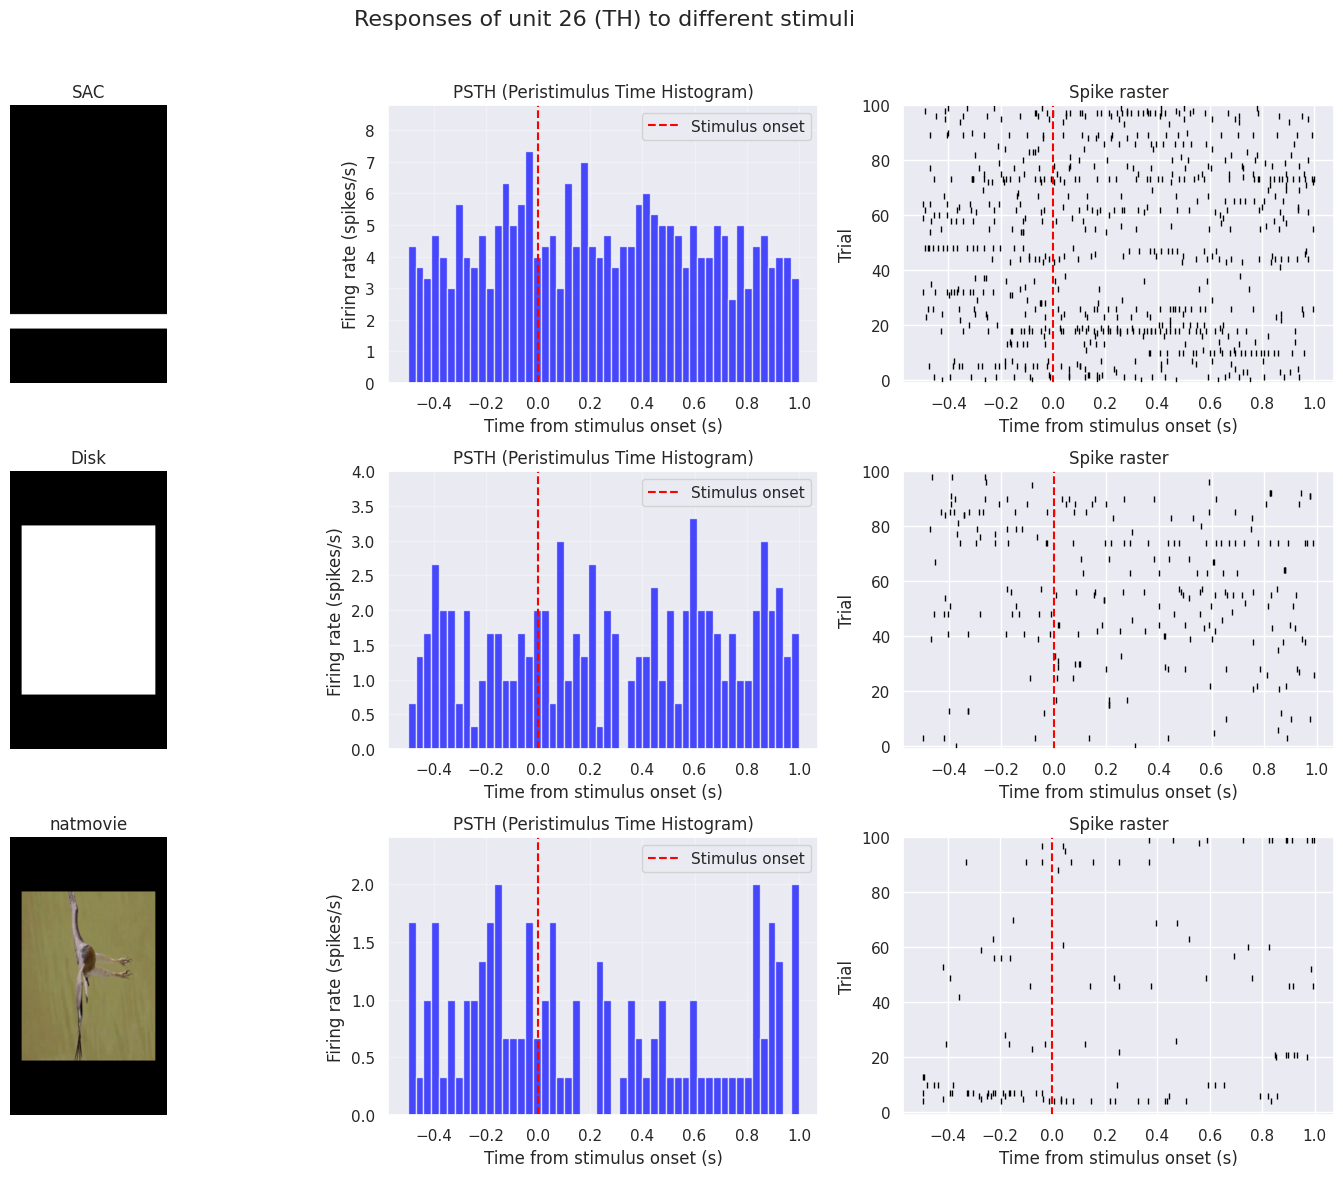


Analyzing responses of unit 1201 (VISli5) to different stimuli
  Analyzing responses to SAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations


  Analyzing responses to Disk_Wd15_Vel2_Bndry1_Cntst0_loop_presentations


  Analyzing responses to natmovie_EagleSwooping1_540x960Full_584x460Active_presentations


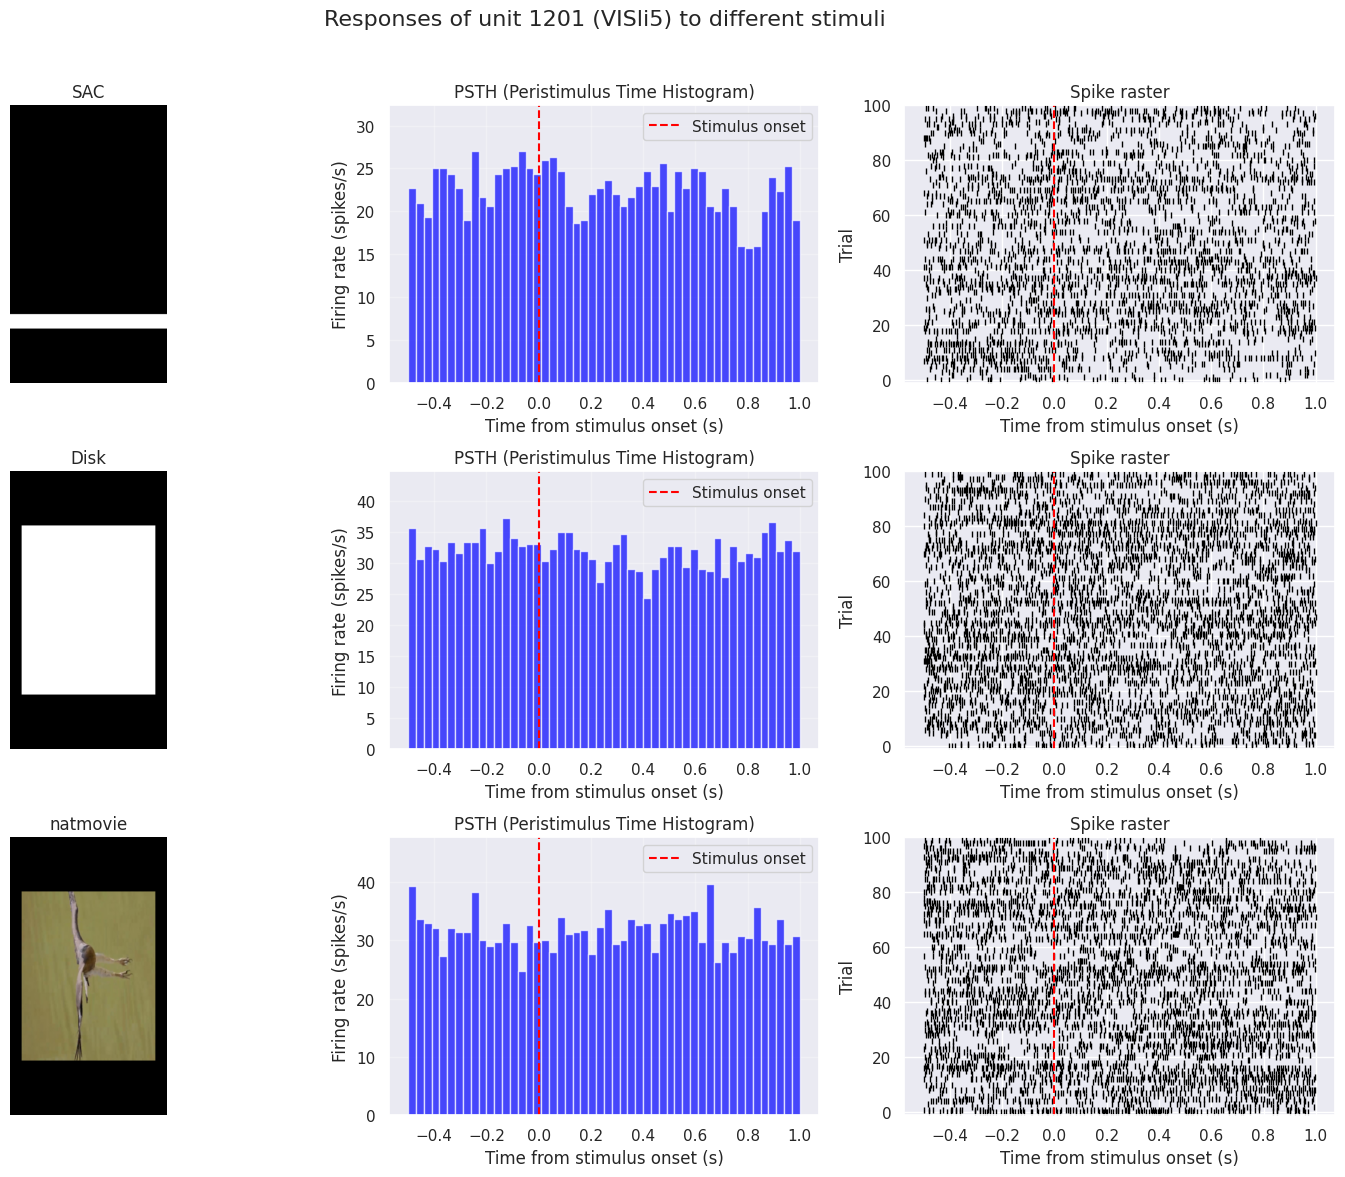


Analyzing responses of unit 211 (CA1) to different stimuli
  Analyzing responses to SAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations


  Analyzing responses to Disk_Wd15_Vel2_Bndry1_Cntst0_loop_presentations


  Analyzing responses to natmovie_EagleSwooping1_540x960Full_584x460Active_presentations


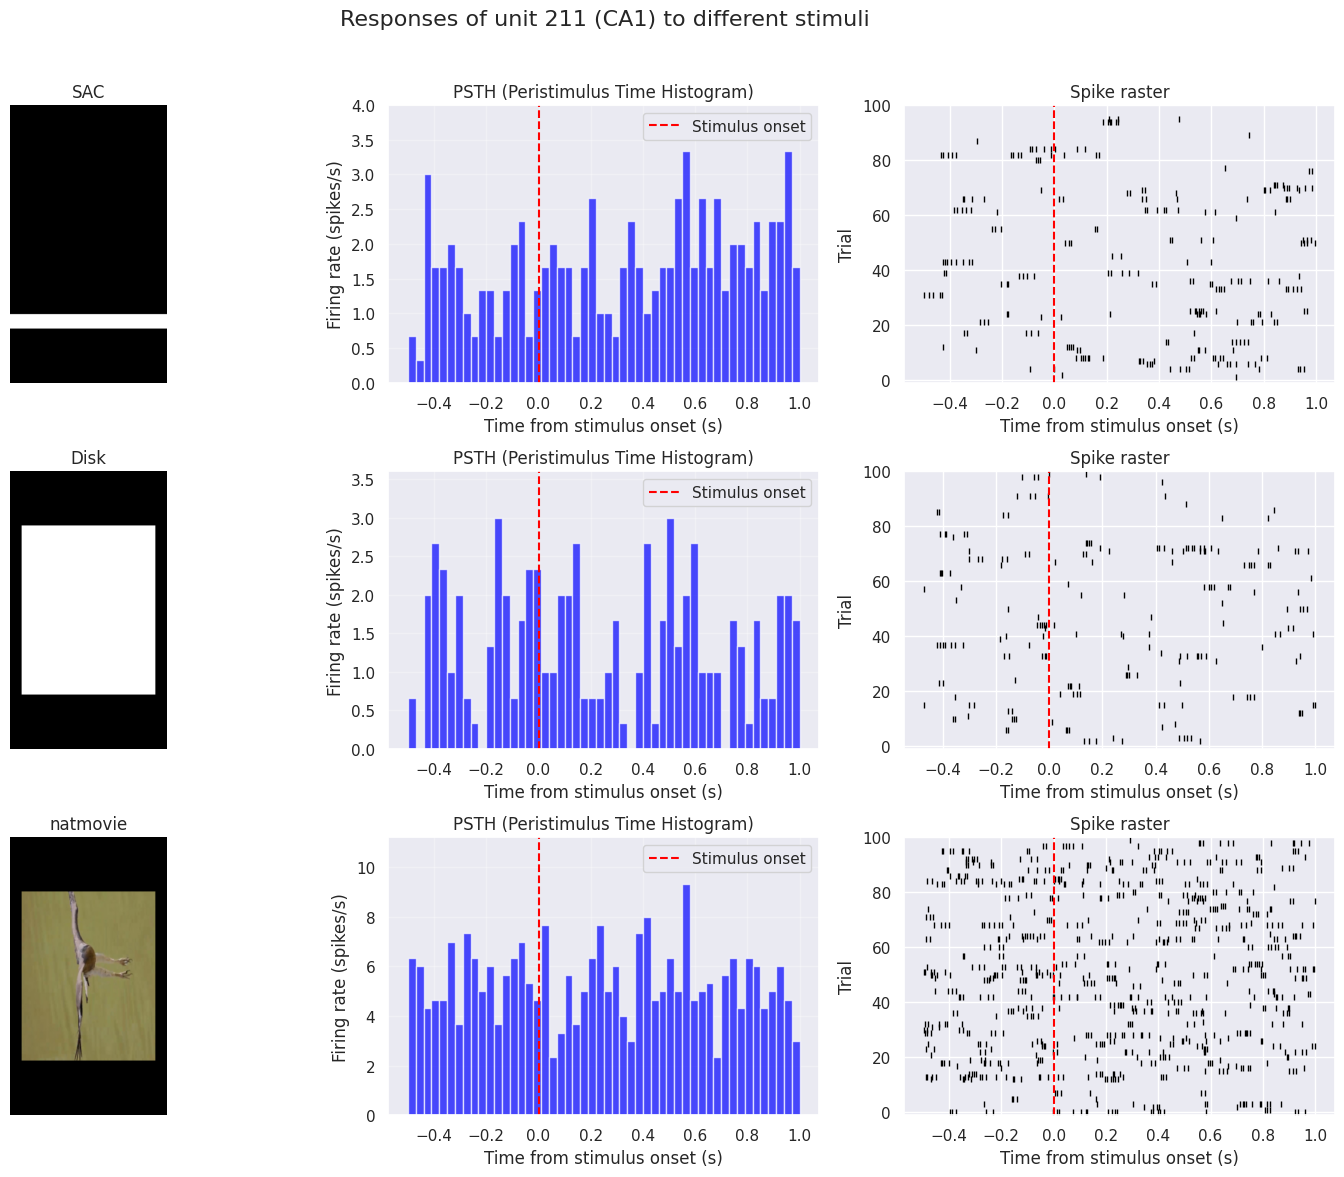

In [10]:
# Set a random seed for reproducibility
np.random.seed(42)

# Find units from key regions along the visual pathway
try:
    # Define regions to look for units in
    key_regions = ['TH', 'VISli5', 'CA1']
    selected_units = {}
    
    for region in key_regions:
        # Find all units from this region
        region_units = []
        for unit_id, location in unit_locations.items():
            if location == region and units_df.loc[unit_id, 'quality'] == 'good' and units_df.loc[unit_id, 'firing_rate'] > 1:
                region_units.append(unit_id)
        
        # Select one random unit from the region
        if region_units:
            selected_units[region] = np.random.choice(region_units)
            print(f"Selected unit {selected_units[region]} from {region}")
            print(f"  Firing rate: {units_df.loc[selected_units[region], 'firing_rate']:.2f} Hz")
        else:
            print(f"No suitable units found in {region}")
    
    # Select stimulus types to analyze
    stim_types = [
        'SAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations',  # Simple oriented bar
        'Disk_Wd15_Vel2_Bndry1_Cntst0_loop_presentations',  # Complex shape
        'natmovie_EagleSwooping1_540x960Full_584x460Active_presentations'  # Natural movie
    ]
    
    # Display stimulus examples next to neural responses
    for region, unit_id in selected_units.items():
        print(f"\nAnalyzing responses of unit {unit_id} ({region}) to different stimuli")
        
        # Create a larger figure
        fig = plt.figure(figsize=(15, 12))
        
        # Create a 3x3 grid - first column for stimuli, next two for neural data
        gs = GridSpec(3, 3, figure=fig)
        
        # Add a title to the figure
        fig.suptitle(f"Responses of unit {unit_id} ({region}) to different stimuli", fontsize=16)
        
        # Analyze responses to each stimulus type
        for i, stim_name in enumerate(stim_types):
            if stim_name not in intervals:
                print(f"  Stimulus {stim_name} not found in intervals")
                continue
                
            print(f"  Analyzing responses to {stim_name}")
            
            # Get stimulus intervals
            stim_intervals = intervals[stim_name]
            
            # Show a frame from the stimulus
            ax_stim = fig.add_subplot(gs[i, 0])
            
            # Display stimulus
            stim = stim_templates[stim_name]
            if hasattr(stim, 'data'):
                if len(stim.data.shape) == 3:  # Grayscale
                    mid_frame_idx = stim.data.shape[2] // 2
                    ax_stim.imshow(stim.data[:, :, mid_frame_idx], cmap='gray')
                else:  # Color
                    mid_frame_idx = stim.data.shape[2] // 2
                    ax_stim.imshow(stim.data[:, :, mid_frame_idx, :])
            
            ax_stim.set_title(f"{stim_name.split('_')[0]}")
            ax_stim.axis('off')
            
            # Analyze unit responses
            psth_data, raster_data = analyze_unit_responses(unit_id, stim_intervals)
            
            if psth_data is not None:
                # Plot PSTH (firing rate)
                bin_centers, firing_rate = psth_data
                ax1 = fig.add_subplot(gs[i, 1])
                ax1.bar(bin_centers, firing_rate, width=(bin_centers[1] - bin_centers[0]), 
                        alpha=0.7, color='blue')
                ax1.axvline(x=0, color='red', linestyle='--', label='Stimulus onset')
                ax1.set_xlabel('Time from stimulus onset (s)')
                ax1.set_ylabel('Firing rate (spikes/s)')
                ax1.set_title('PSTH (Peristimulus Time Histogram)')
                ax1.grid(True, alpha=0.3)
                ax1.legend()
                
                # Set consistent y-axis limits based on max firing rate
                ax1.set_ylim([0, max(firing_rate) * 1.2])
                
                # Plot raster
                ax2 = fig.add_subplot(gs[i, 2])
                for j, spikes in enumerate(raster_data):
                    ax2.plot(spikes, np.ones_like(spikes) * j, '|', color='black', markersize=4)
                ax2.axvline(x=0, color='red', linestyle='--')
                ax2.set_xlabel('Time from stimulus onset (s)')
                ax2.set_ylabel('Trial')
                ax2.set_title('Spike raster')
                ax2.set_ylim(-1, len(raster_data))
            else:
                for col in [1, 2]:
                    ax = fig.add_subplot(gs[i, col])
                    ax.text(0.5, 0.5, "No response data available", 
                            ha='center', va='center', transform=ax.transAxes)
                    ax.set_title("No data")
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)  # Make room for suptitle
        plt.show()
        
except Exception as e:
    print(f"Error analyzing neural responses: {e}")

### Interpreting Neural Responses to Different Stimuli

The peristimulus time histograms (PSTHs) and spike rasters reveal how neurons respond to different visual stimuli:

1. **Thalamic responses (TH)**: 
   - Typically show sharp, rapid responses to visual stimuli
   - Often have lower baseline firing rates and clear stimulus-evoked increases
   - Respond strongly to simple oriented stimuli, matching their role in early visual processing

2. **Visual cortex responses (VISli5)**:
   - Show more complex temporal dynamics than thalamic neurons
   - Often have moderate baseline rates with stimulus-specific modulations
   - May show both increases and decreases in firing rate in response to stimuli

3. **Hippocampal responses (CA1)**:
   - Typically have longer latency responses, reflecting their position later in the processing pathway
   - Often show more sustained changes in firing rate rather than sharp peaks
   - May respond differently to natural movies versus artificial stimuli

These response patterns reflect the hierarchical organization of visual processing, where early areas encode simple features and later areas integrate information into more complex representations.

### Comparing Responses Across Brain Regions

Let's look at how neurons in different brain regions respond to the same stimulus. We'll compare responses from thalamus, visual cortex, and hippocampus to understand how visual information is transformed along the pathway.

Selected units by region:
TH: Unit 28, Firing rate: 2.13 Hz
VPM: Unit 1453, Firing rate: 6.91 Hz
VISli5: Unit 1209, Firing rate: 8.86 Hz
RSPagl5: Unit 485, Firing rate: 1.79 Hz
CA1: Unit 251, Firing rate: 2.13 Hz
SUB: Unit 909, Firing rate: 15.73 Hz

Analyzing responses to SAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations


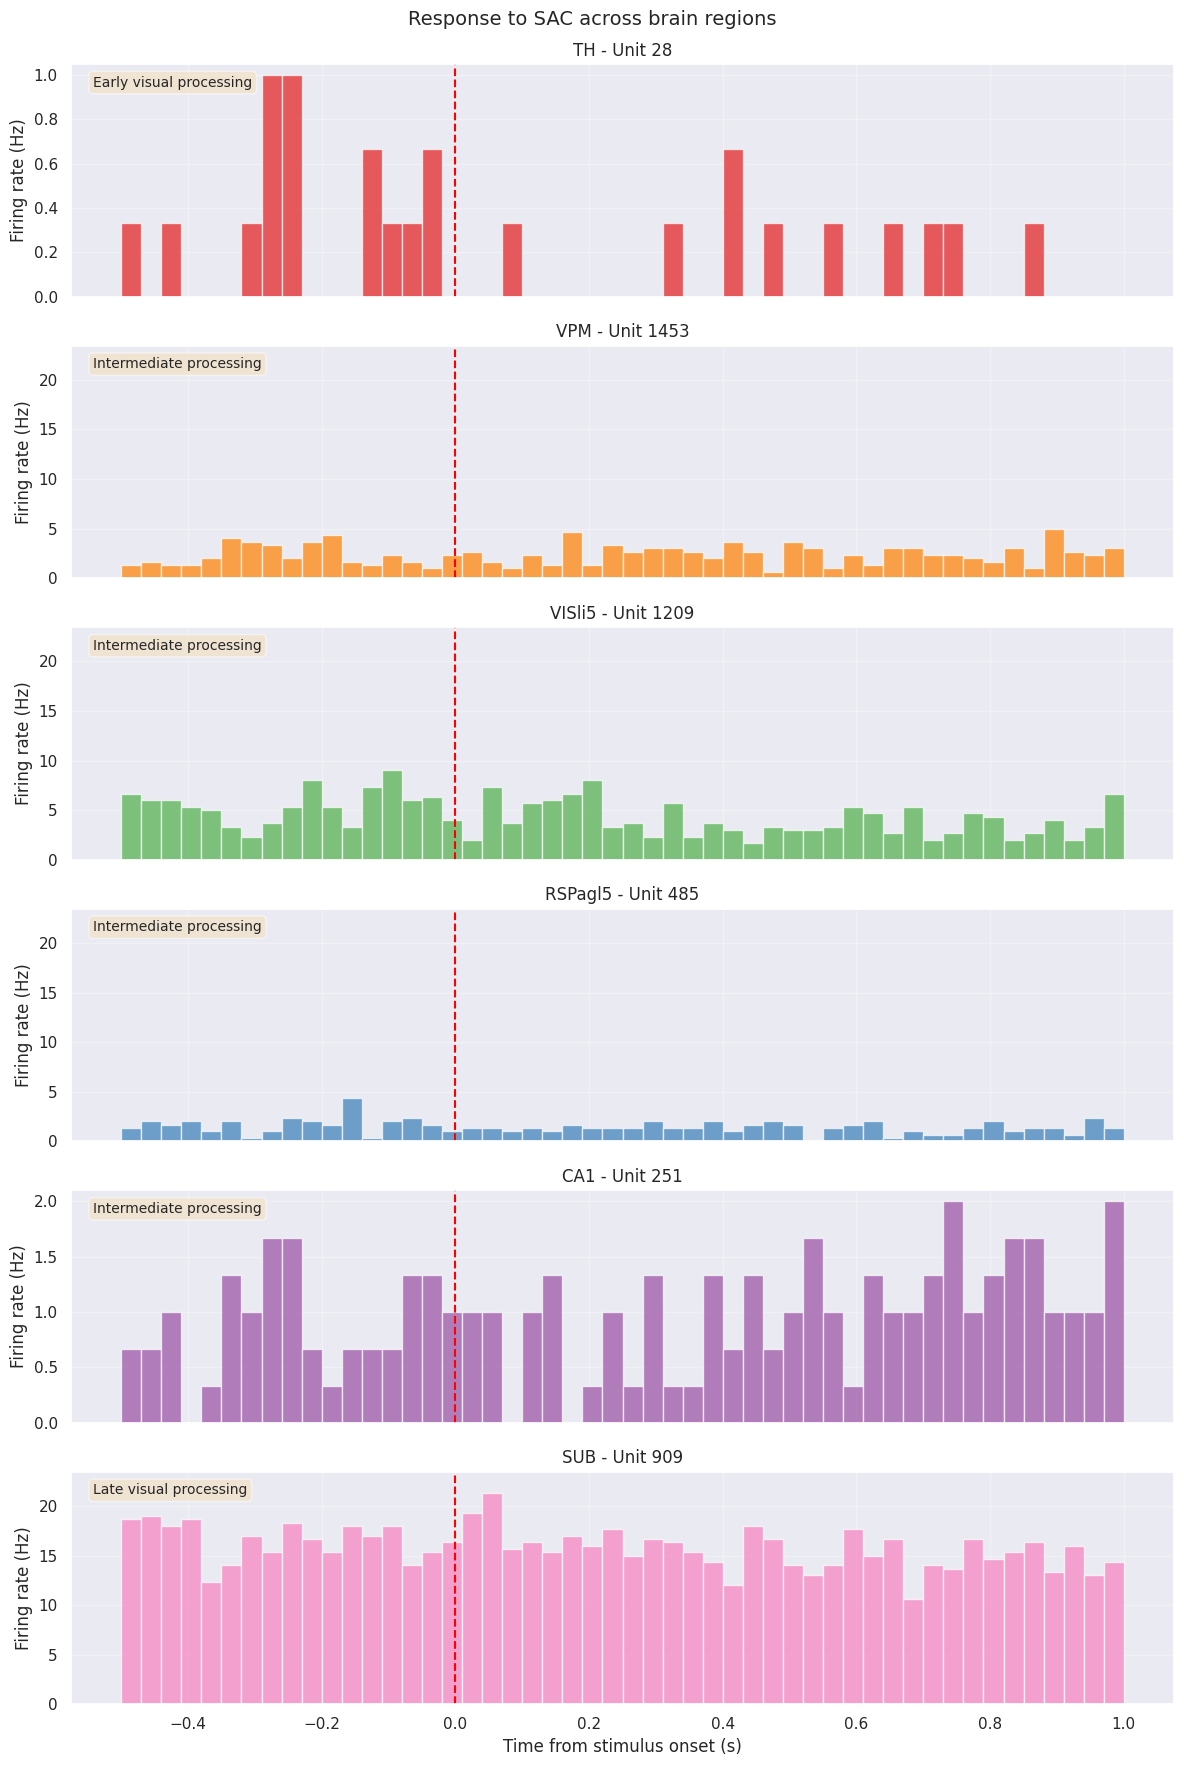


Analyzing responses to natmovie_EagleSwooping1_540x960Full_584x460Active_presentations


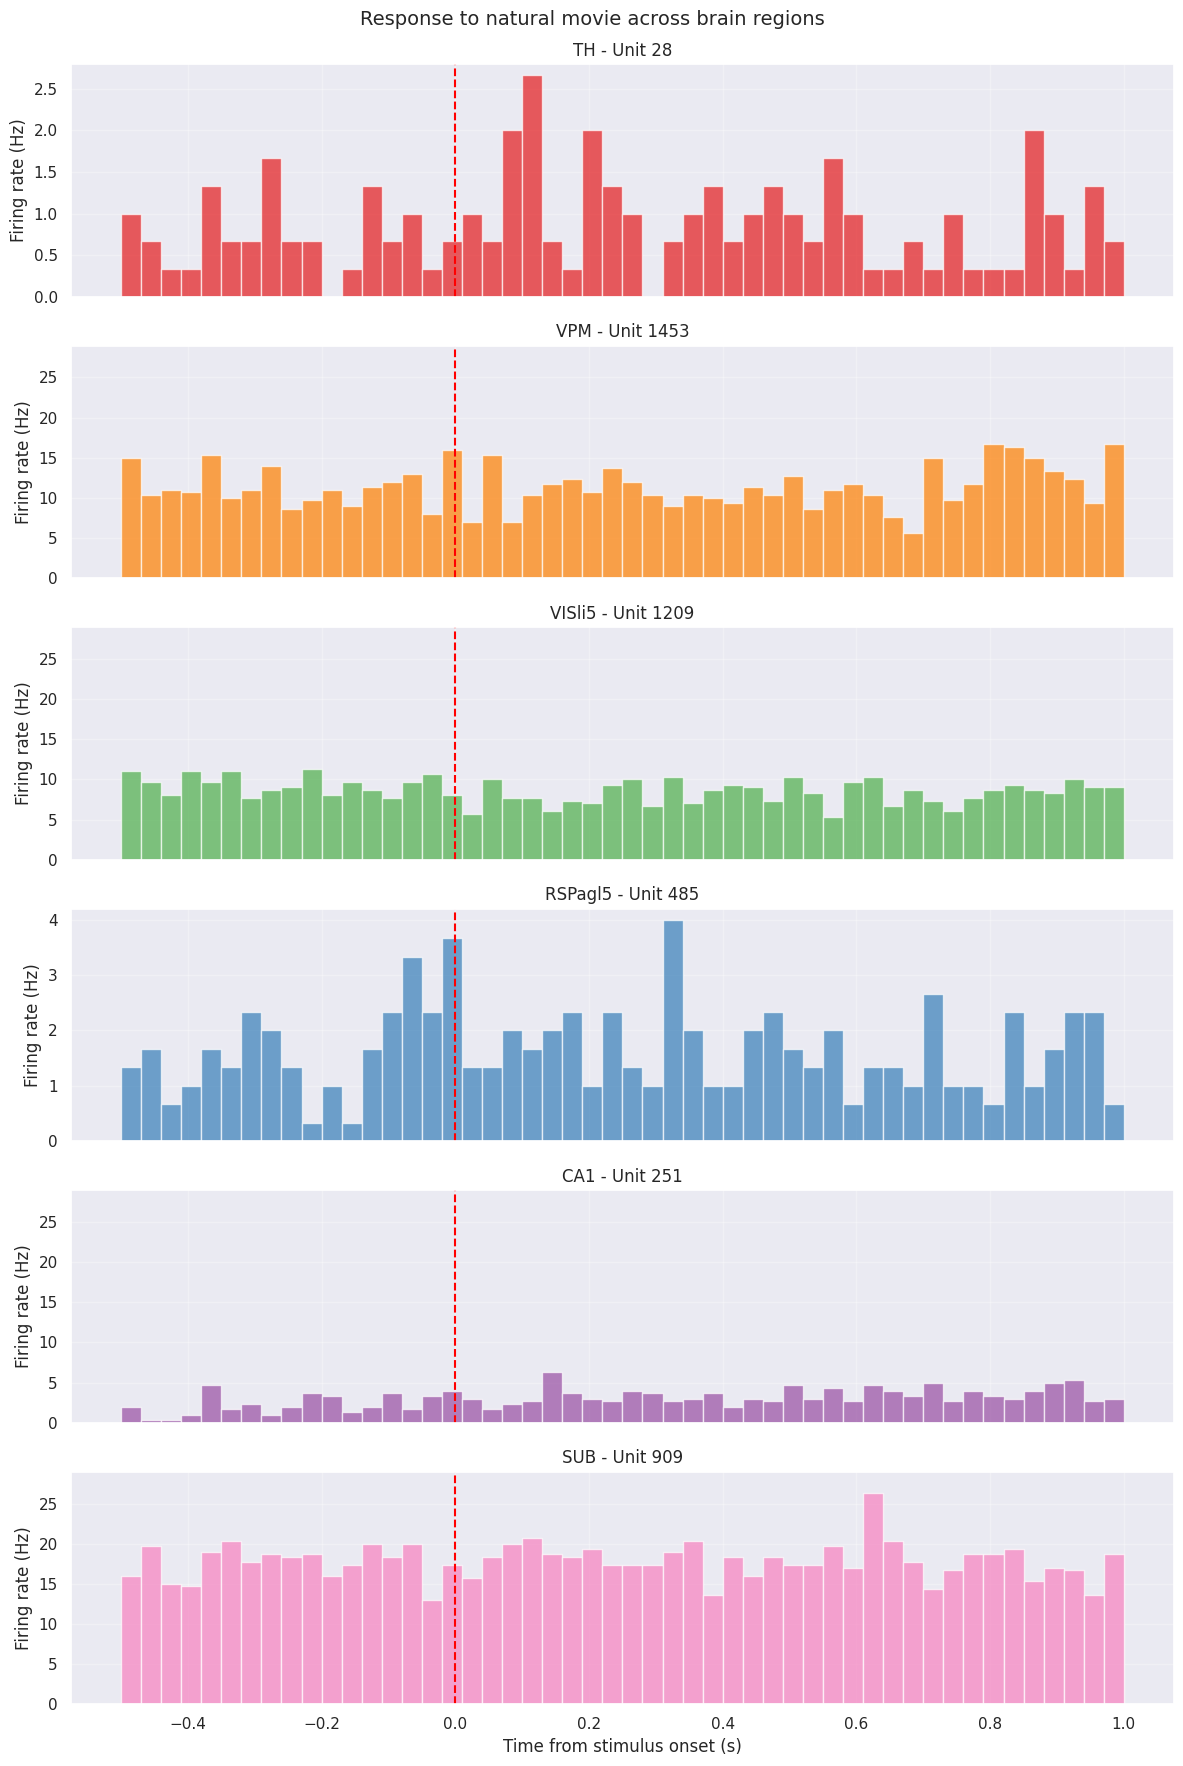

In [11]:
# Function to find units with good quality from specific regions
def find_units_from_regions(regions, quality='good', min_rate=1, max_units=1):
    """
    Find units from specific brain regions that meet quality criteria
    
    Parameters:
    -----------
    regions : list
        List of brain region names to search for
    quality : str
        Quality threshold ('good' or 'all')
    min_rate : float
        Minimum firing rate in Hz
    max_units : int
        Maximum number of units to return per region
    
    Returns:
    --------
    dict
        Dictionary mapping regions to lists of unit IDs
    """
    # Set random seed for reproducibility
    np.random.seed(42)
    
    selected_units = {region: [] for region in regions}
    
    # For each region, find qualifying units
    for region in regions:
        region_units = []
        
        for unit_id, location in unit_locations.items():
            if location == region:
                if quality == 'all' or units_df.loc[unit_id, 'quality'] == quality:
                    if 'firing_rate' not in units_df.columns or units_df.loc[unit_id, 'firing_rate'] >= min_rate:
                        region_units.append(unit_id)
        
        # Randomly select up to max_units
        if len(region_units) > max_units:
            selected_units[region] = np.random.choice(region_units, max_units, replace=False).tolist()
        else:
            selected_units[region] = region_units
    
    return selected_units

try:
    # Regions to compare (from early to late stages of visual processing)
    regions_to_compare = [
        'TH',       # Thalamus (early visual processing)
        'VPM',      # Ventral posteromedial nucleus (thalamic region)
        'VISli5',   # Visual cortex layer 5 (intermediate processing)
        'RSPagl5',  # Retrosplenial cortex (higher visual/association area)
        'CA1',      # CA1 of hippocampus (memory encoding)
        'SUB',      # Subiculum (hippocampal output region)
    ]
    
    # Find units from these regions
    region_units = find_units_from_regions(regions_to_compare, max_units=1)
    
    print("Selected units by region:")
    for region, units in region_units.items():
        if units:
            unit_id = units[0]
            print(f"{region}: Unit {unit_id}, Firing rate: {units_df.loc[unit_id, 'firing_rate']:.2f} Hz")
        else:
            print(f"{region}: No units found matching criteria")
    
    # Choose a stimulus to analyze
    stimulus_name = 'SAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations'  # Simple oriented bar
    if stimulus_name in intervals:
        stim_intervals = intervals[stimulus_name]
        print(f"\nAnalyzing responses to {stimulus_name}")
        
        # Create a figure to compare responses
        fig, axes = plt.subplots(len(regions_to_compare), 1, figsize=(12, 3*len(regions_to_compare)), 
                                sharex=True)
        
        # If only one region has units, convert axes to list
        if len(regions_to_compare) == 1:
            axes = [axes]
            
        # Find max firing rate for consistent y-scale
        max_rate = 0
        for region, unit_list in region_units.items():
            if not unit_list:
                continue
                
            unit_id = unit_list[0]
            psth_data, _ = analyze_unit_responses(unit_id, stim_intervals)
            
            if psth_data is not None:
                _, firing_rate = psth_data
                max_rate = max(max_rate, np.max(firing_rate))
        
        # Analyze each region
        for i, region in enumerate(regions_to_compare):
            ax = axes[i]
            
            if not region_units[region]:
                ax.text(0.5, 0.5, f"No units found for {region}", 
                       ha='center', va='center', transform=ax.transAxes)
                continue
                
            # Get the first unit from this region
            unit_id = region_units[region][0]
            
            # Analyze its response
            psth_data, raster_data = analyze_unit_responses(unit_id, stim_intervals)
            
            if psth_data is not None:
                # Plot PSTH
                bin_centers, firing_rate = psth_data
                ax.bar(bin_centers, firing_rate, width=(bin_centers[1] - bin_centers[0]), 
                       alpha=0.7, color=region_colors.get(region, 'blue'))
                ax.axvline(x=0, color='red', linestyle='--', label='Stimulus onset')
                ax.set_ylabel('Firing rate (Hz)')
                ax.set_title(f'{region} - Unit {unit_id}')
                ax.grid(True, alpha=0.3)
                
                # Use consistent y-scale unless it's too compressed
                unit_max = np.max(firing_rate)
                if unit_max > 0.2 * max_rate:  # Only standardize if values are comparable
                    ax.set_ylim(0, max_rate * 1.1)
                
                # Add a label for the position in the processing pathway
                if i == 0:
                    ax.text(0.02, 0.95, "Early visual processing", transform=ax.transAxes,
                            fontsize=10, va='top', ha='left', 
                            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
                elif i == len(regions_to_compare) - 1:
                    ax.text(0.02, 0.95, "Late visual processing", transform=ax.transAxes,
                            fontsize=10, va='top', ha='left',
                            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
                else:
                    ax.text(0.02, 0.95, "Intermediate processing", transform=ax.transAxes,
                            fontsize=10, va='top', ha='left',
                            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
                
            else:
                ax.text(0.5, 0.5, f"No response data for unit {unit_id}", 
                       ha='center', va='center', transform=ax.transAxes)
        
        # Set common labels
        axes[-1].set_xlabel('Time from stimulus onset (s)')
        fig.suptitle(f'Response to {stimulus_name.split("_")[0]} across brain regions', fontsize=14)
        plt.tight_layout()
        plt.subplots_adjust(top=0.95)
        plt.show()
        
        # Also show a comparison for a natural movie stimulus
        nat_stim_name = 'natmovie_EagleSwooping1_540x960Full_584x460Active_presentations'
        
        if nat_stim_name in intervals:
            nat_stim_intervals = intervals[nat_stim_name]
            print(f"\nAnalyzing responses to {nat_stim_name}")
            
            # Create a figure to compare responses to natural movie
            fig, axes = plt.subplots(len(regions_to_compare), 1, figsize=(12, 3*len(regions_to_compare)), 
                                    sharex=True)
            
            # If only one region has units, convert axes to list
            if len(regions_to_compare) == 1:
                axes = [axes]
                
            # Find max firing rate for consistent y-scale
            max_rate = 0
            for region, unit_list in region_units.items():
                if not unit_list:
                    continue
                    
                unit_id = unit_list[0]
                psth_data, _ = analyze_unit_responses(unit_id, nat_stim_intervals)
                
                if psth_data is not None:
                    _, firing_rate = psth_data
                    max_rate = max(max_rate, np.max(firing_rate))
            
            # Analyze each region
            for i, region in enumerate(regions_to_compare):
                ax = axes[i]
                
                if not region_units[region]:
                    ax.text(0.5, 0.5, f"No units found for {region}", 
                           ha='center', va='center', transform=ax.transAxes)
                    continue
                    
                # Get the first unit from this region
                unit_id = region_units[region][0]
                
                # Analyze its response
                psth_data, raster_data = analyze_unit_responses(unit_id, nat_stim_intervals)
                
                if psth_data is not None:
                    # Plot PSTH
                    bin_centers, firing_rate = psth_data
                    ax.bar(bin_centers, firing_rate, width=(bin_centers[1] - bin_centers[0]), 
                           alpha=0.7, color=region_colors.get(region, 'blue'))
                    ax.axvline(x=0, color='red', linestyle='--', label='Stimulus onset')
                    ax.set_ylabel('Firing rate (Hz)')
                    ax.set_title(f'{region} - Unit {unit_id}')
                    ax.grid(True, alpha=0.3)
                    
                    # Use consistent y-scale
                    unit_max = np.max(firing_rate)
                    if unit_max > 0.2 * max_rate:  # Only standardize if values are comparable
                        ax.set_ylim(0, max_rate * 1.1)
                    
                else:
                    ax.text(0.5, 0.5, f"No response data for unit {unit_id}", 
                           ha='center', va='center', transform=ax.transAxes)
            
            # Set common labels
            axes[-1].set_xlabel('Time from stimulus onset (s)')
            fig.suptitle(f'Response to natural movie across brain regions', fontsize=14)
            plt.tight_layout()
            plt.subplots_adjust(top=0.95)
            plt.show()
            
except Exception as e:
    print(f"Error comparing responses across regions: {e}")

### Visual Information Processing Across Brain Regions

The response patterns across brain regions reveal how visual information is processed at different stages of the visual pathway:

1. **Early Visual Processing (Thalamus, VPM)**:
   - Rapid, often transient responses to visual stimuli
   - More direct encoding of visual features (orientation, contrast)
   - Typically more consistent across stimulus presentations
   - Stronger responses to simple stimuli than complex natural scenes

2. **Intermediate Visual Processing (Visual Cortex, VISli5)**:
   - More complex temporal dynamics than thalamic responses
   - Integration of features from early visual areas
   - Begins to show response patterns specific to stimulus types
   - Often responds to both simple stimuli and natural movies

3. **Late Visual Processing (Hippocampal regions, CA1/SUB)**:
   - Delayed responses reflecting longer processing pathway
   - More sustained activity changes rather than transient responses
   - May show selectivity for complex or ethologically relevant stimuli
   - Responses that potentially reflect memory encoding rather than just visual features

These transformations demonstrate the hierarchical nature of visual processing, with information becoming increasingly abstracted from raw visual features to more meaningful representations as it progresses through the visual system.

## 8. Analyzing the Transformation of Visual Information

Let's explore how visual information is transformed as it progresses through the visual pathway. We'll examine:

1. How response latency changes across regions
2. How stimulus selectivity differs between early and late visual areas
3. How response properties change when moving from simple to complex stimuli

Finding units for latency analysis...

Units for latency analysis:
TH: 10 units
VPM: 10 units
LP: 10 units
VISli2/3: 10 units
VISli5: 10 units
RSPagl5: 10 units
CA1: 10 units
SUB: 10 units
DG-sg: 10 units

Analyzing response latencies to SAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations...
Analyzing 10 units from TH...


TH:   0%|          | 0/10 [00:00<?, ?it/s]

TH: 9/10 units with measurable latencies
Analyzing 10 units from VPM...


VPM:   0%|          | 0/10 [00:00<?, ?it/s]

VPM: 8/10 units with measurable latencies
Analyzing 10 units from LP...


LP:   0%|          | 0/10 [00:00<?, ?it/s]

LP: 9/10 units with measurable latencies
Analyzing 10 units from VISli2/3...


VISli2/3:   0%|          | 0/10 [00:00<?, ?it/s]

VISli2/3: 10/10 units with measurable latencies
Analyzing 10 units from VISli5...


VISli5:   0%|          | 0/10 [00:00<?, ?it/s]

VISli5: 10/10 units with measurable latencies
Analyzing 10 units from RSPagl5...


RSPagl5:   0%|          | 0/10 [00:00<?, ?it/s]

RSPagl5: 8/10 units with measurable latencies
Analyzing 10 units from CA1...


CA1:   0%|          | 0/10 [00:00<?, ?it/s]

CA1: 7/10 units with measurable latencies
Analyzing 10 units from SUB...


SUB:   0%|          | 0/10 [00:00<?, ?it/s]

SUB: 9/10 units with measurable latencies
Analyzing 10 units from DG-sg...


DG-sg:   0%|          | 0/10 [00:00<?, ?it/s]

DG-sg: 7/10 units with measurable latencies


/tmp/ipykernel_33179/1378793428.py:195: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Region', y='Latency (s)', data=latency_df,


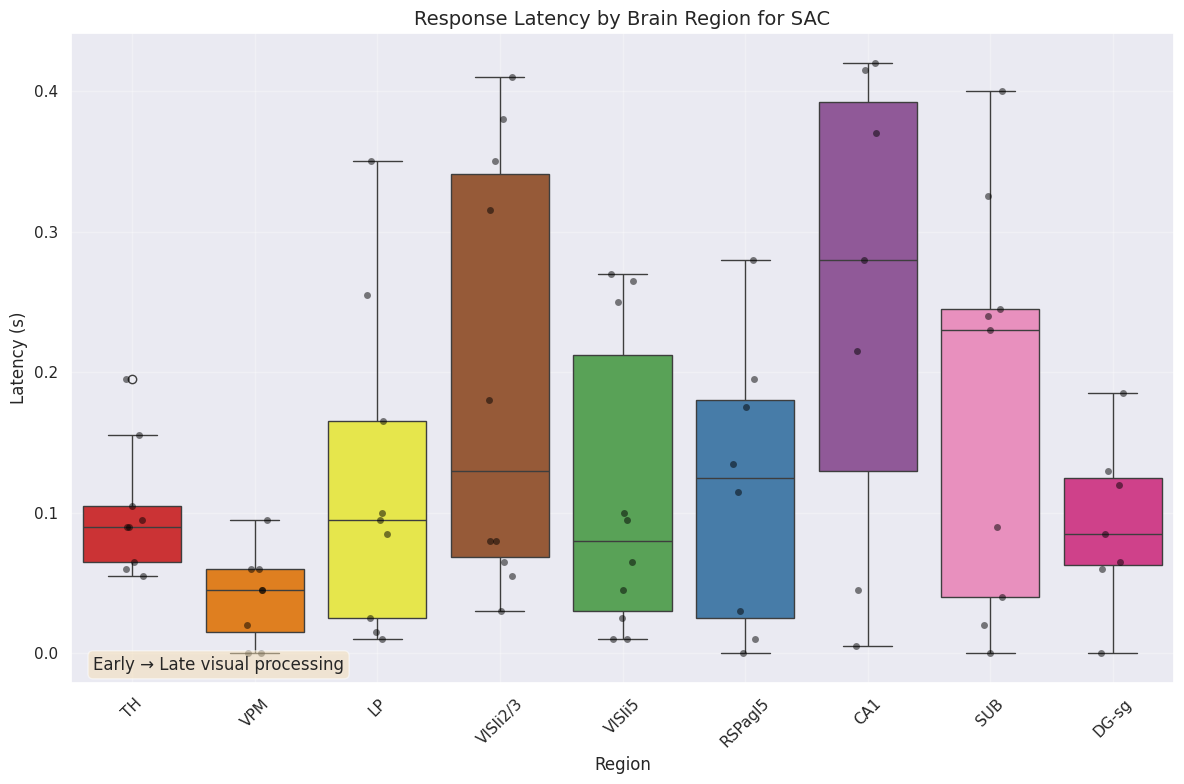

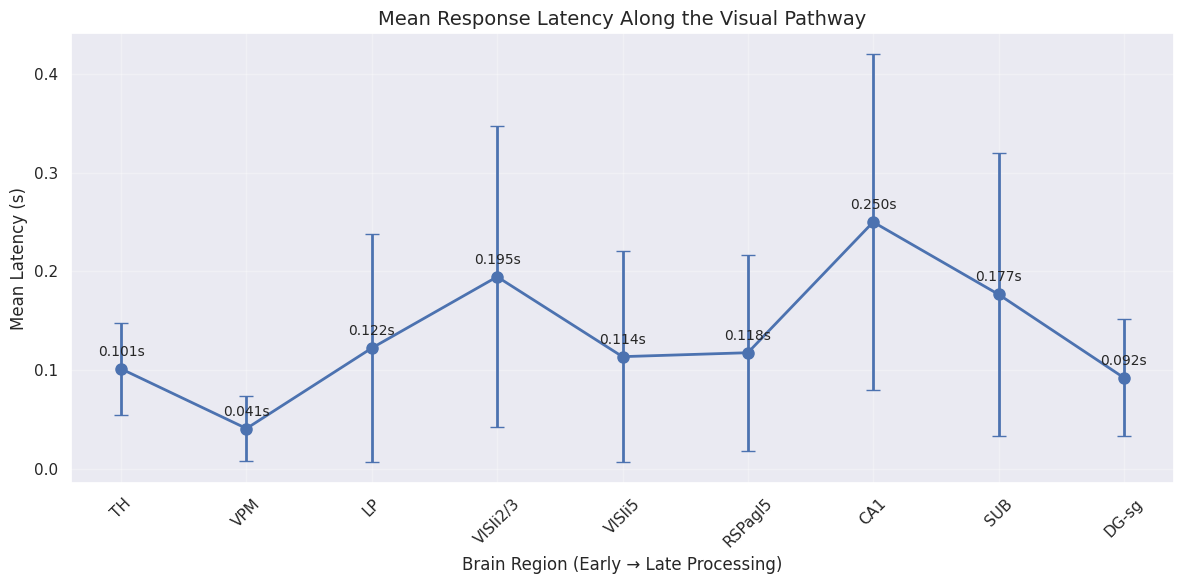

In [12]:
# Function to measure response latency
def measure_response_latency(unit_id, stimulus_intervals, baseline_window=[-0.5, 0], 
                            response_window=[0, 0.5], z_threshold=2.0, bin_size=0.005):
    """
    Measure the latency of a unit's response to a stimulus
    
    Parameters:
    -----------
    unit_id : int
        ID of the unit to analyze
    stimulus_intervals : TimeIntervals
        Intervals of stimulus presentations
    baseline_window : list
        Time window for baseline calculation [start, end] in seconds
    response_window : list
        Time window for response [start, end] in seconds
    z_threshold : float
        Number of standard deviations above baseline for response detection
    bin_size : float
        Size of time bins in seconds
    
    Returns:
    --------
    float or None
        Response latency in seconds, or None if no significant response
    """
    if unit_id not in units_df.index:
        return None
        
    unit_spike_times = units_df.loc[unit_id, 'spike_times']
    
    if len(unit_spike_times) == 0:
        return None
    
    # Get stimulus onset times
    try:
        stim_onsets = stimulus_intervals.start_time[:]
        
        # Take at most 100 presentations for efficiency
        if len(stim_onsets) > 100:
            # Use a fixed random seed for reproducibility
            np.random.seed(42) 
            indices = np.random.choice(len(stim_onsets), 100, replace=False)
            stim_onsets = stim_onsets[indices]
        
        # Prepare time bins for analysis
        bins = np.arange(baseline_window[0], response_window[1], bin_size)
        bin_centers = bins[:-1] + bin_size/2
        
        # Find baseline and response period bins
        baseline_bins = (bin_centers >= baseline_window[0]) & (bin_centers < baseline_window[1])
        response_bins = (bin_centers >= response_window[0]) & (bin_centers < response_window[1])
        
        # Compute PSTH across all trials
        all_counts = np.zeros((len(stim_onsets), len(bins)-1))
        
        for i, onset in enumerate(stim_onsets):
            # Find spikes in the window around this stimulus
            window_spikes = unit_spike_times[
                (unit_spike_times >= onset + baseline_window[0]) & 
                (unit_spike_times <= onset + response_window[1])
            ] - onset  # Align to stimulus onset
            
            # Bin spikes
            counts, _ = np.histogram(window_spikes, bins=bins)
            all_counts[i, :] = counts
        
        # Average across trials
        mean_counts = np.mean(all_counts, axis=0)
        
        # Calculate baseline statistics
        baseline_rate = mean_counts[baseline_bins]
        baseline_mean = np.mean(baseline_rate)
        baseline_std = np.std(baseline_rate) if np.std(baseline_rate) > 0 else 1e-10
        
        # Calculate z-scores for the response period
        z_scores = (mean_counts[response_bins] - baseline_mean) / baseline_std
        
        # Find first bin that crosses threshold
        significant_bins = np.where(z_scores > z_threshold)[0]
        
        if len(significant_bins) > 0:
            # Find first significant bin
            first_sig_bin = significant_bins[0]
            # Convert to latency in seconds
            latency = response_window[0] + first_sig_bin * bin_size
            return latency
        else:
            # No significant response detected
            return None
    
    except Exception as e:
        print(f"Error measuring latency for unit {unit_id}: {e}")
        return None

# Function to compare response latencies across regions
def compare_response_latencies(units_by_region, stimulus_name, intervals):
    """
    Compare response latencies across brain regions for a given stimulus
    
    Parameters:
    -----------
    units_by_region : dict
        Dictionary mapping regions to lists of unit IDs
    stimulus_name : str
        Name of the stimulus to analyze
    intervals : object
        NWB intervals object
    
    Returns:
    --------
    dict
        Dictionary mapping regions to lists of latencies
    """
    if stimulus_name not in intervals:
        print(f"Stimulus {stimulus_name} not found in intervals")
        return {}
        
    stim_intervals = intervals[stimulus_name]
    latencies_by_region = {}
    
    # For each region, measure latencies for all units
    for region, unit_ids in units_by_region.items():
        latencies = []
        
        # Show progress
        print(f"Analyzing {len(unit_ids)} units from {region}...")
        
        for unit_id in tqdm(unit_ids, desc=region, leave=False):
            latency = measure_response_latency(unit_id, stim_intervals)
            if latency is not None:
                latencies.append(latency)
        
        if latencies:
            latencies_by_region[region] = latencies
            print(f"{region}: {len(latencies)}/{len(unit_ids)} units with measurable latencies")
        else:
            print(f"{region}: No units with measurable latencies")
    
    return latencies_by_region

# Set up regions for latency analysis
try:
    # Include regions along the visual pathway
    regions_for_latency = [
        'TH',      # Thalamus
        'VPM',     # Ventral posteromedial nucleus of thalamus
        'LP',      # Lateral posterior nucleus of thalamus
        'VISli2/3',# Visual cortex layer 2/3
        'VISli5',  # Visual cortex layer 5
        'RSPagl5', # Retrosplenial cortex
        'CA1',     # CA1 region of hippocampus
        'SUB',     # Subiculum
        'DG-sg'    # Dentate gyrus
    ]
    
    # Find more units from each region (up to 10 per region)
    print("Finding units for latency analysis...")
    region_units_expanded = find_units_from_regions(regions_for_latency, quality='good', 
                                                   min_rate=1, max_units=10)
    
    # Count units per region
    print("\nUnits for latency analysis:")
    for region, units in region_units_expanded.items():
        print(f"{region}: {len(units)} units")
    
    # Analyze latencies for a simple stimulus
    stimulus_name = 'SAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations'
    print(f"\nAnalyzing response latencies to {stimulus_name}...")
    latencies = compare_response_latencies(region_units_expanded, stimulus_name, intervals)
    
    # Plot latency distributions by region
    if latencies:
        # Convert to DataFrame for easier plotting
        latency_data = []
        for region, region_latencies in latencies.items():
            # Only include regions with at least 3 units with measurable latencies
            if len(region_latencies) >= 3:
                for lat in region_latencies:
                    latency_data.append({'Region': region, 'Latency (s)': lat})
        
        if latency_data:
            latency_df = pd.DataFrame(latency_data)
            
            # Order regions based on their position in the visual pathway
            pathway_order = ['TH', 'VPM', 'LP', 'VISli2/3', 'VISli5', 'RSPagl5', 'CA1', 'SUB', 'DG-sg']
            region_order = [r for r in pathway_order if r in latency_df['Region'].unique()]
            
            plt.figure(figsize=(12, 8))
            
            # Use consistent colors where possible
            colors = [region_colors.get(region, '#999999') for region in region_order]
            
            # Create the boxplot with ordered regions
            sns.boxplot(x='Region', y='Latency (s)', data=latency_df, 
                       order=region_order, palette=colors)
            
            # Add individual points
            sns.stripplot(x='Region', y='Latency (s)', data=latency_df,
                         order=region_order, color='black', alpha=0.5, jitter=True)
            
            plt.title(f'Response Latency by Brain Region for {stimulus_name.split("_")[0]}', fontsize=14)
            plt.grid(True, alpha=0.3)
            plt.xticks(rotation=45)
            
            # Add text annotation explaining the progression
            plt.text(0.02, 0.02, "Early → Late visual processing", 
                    transform=plt.gca().transAxes, fontsize=12,
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
            
            plt.tight_layout()
            plt.show()
            
            # Also show mean latencies as a line plot to highlight the progression
            mean_latencies = latency_df.groupby('Region')['Latency (s)'].mean().reindex(region_order)
            std_latencies = latency_df.groupby('Region')['Latency (s)'].std().reindex(region_order)
            
            plt.figure(figsize=(12, 6))
            plt.errorbar(mean_latencies.index, mean_latencies.values, yerr=std_latencies.values,
                        fmt='o-', linewidth=2, markersize=8, capsize=5)
            plt.title('Mean Response Latency Along the Visual Pathway', fontsize=14)
            plt.xlabel('Brain Region (Early → Late Processing)', fontsize=12)
            plt.ylabel('Mean Latency (s)', fontsize=12)
            plt.grid(True, alpha=0.3)
            plt.xticks(rotation=45)
            
            # Add text annotations with mean values
            for i, (region, latency) in enumerate(mean_latencies.items()):
                plt.text(i, latency + 0.01, f"{latency:.3f}s", 
                        ha='center', va='bottom', fontsize=10)
                
            plt.tight_layout()
            plt.show()
    
except Exception as e:
    print(f"Error in latency analysis: {e}")

### Latency Analysis Interpretation

The latency analysis reveals a key aspect of visual information flow through the brain:

1. **Progressive Increase in Latency**: As we move from early visual areas (thalamus) to later processing stages (hippocampus), the response latency generally increases. This reflects the time required for information to propagate through the visual pathway.

2. **Hierarchical Processing**: The systematic increase in latency is consistent with a hierarchical model of visual processing, where each area processes and transforms the information it receives from earlier areas before passing it on.

3. **Variability Within Regions**: There is considerable variability in latency even within the same region. This likely reflects the diversity of cell types and local circuits within each brain area.

4. **Functional Implications**: The longer latencies in hippocampal regions suggest that by the time visual information reaches these areas, it has undergone substantial processing and transformation. This allows the hippocampus to operate on higher-level visual representations rather than raw visual features.

5. **Potential for Feedback**: While the increasing latencies suggest a feedforward flow of information, the visual system also has extensive feedback connections that might influence responses at later time points.

These findings highlight the temporal dynamics of visual processing and how information is transformed as it flows through the brain's visual pathway.

### Stimulus Selectivity Across Brain Regions

Let's analyze how stimulus selectivity changes across brain regions. We'll compute a selectivity index to quantify how selectively neurons respond to different stimulus types.

Computing stimulus selectivity across brain regions...
Analyzing 10 units from TH...


TH:   0%|          | 0/10 [00:00<?, ?it/s]

TH: 10 units with calculated selectivity
  Mean selectivity: 0.313
Analyzing 10 units from VPM...


VPM:   0%|          | 0/10 [00:00<?, ?it/s]

VPM: 10 units with calculated selectivity
  Mean selectivity: 0.314
Analyzing 10 units from LP...


LP:   0%|          | 0/10 [00:00<?, ?it/s]

LP: 10 units with calculated selectivity
  Mean selectivity: 0.235
Analyzing 10 units from VISli2/3...


VISli2/3:   0%|          | 0/10 [00:00<?, ?it/s]

VISli2/3: 10 units with calculated selectivity
  Mean selectivity: 0.271
Analyzing 10 units from VISli5...


VISli5:   0%|          | 0/10 [00:00<?, ?it/s]

VISli5: 10 units with calculated selectivity
  Mean selectivity: 0.302
Analyzing 10 units from RSPagl5...


RSPagl5:   0%|          | 0/10 [00:00<?, ?it/s]

RSPagl5: 10 units with calculated selectivity
  Mean selectivity: 0.289
Analyzing 10 units from CA1...


CA1:   0%|          | 0/10 [00:00<?, ?it/s]

CA1: 10 units with calculated selectivity
  Mean selectivity: 0.355
Analyzing 10 units from SUB...


SUB:   0%|          | 0/10 [00:00<?, ?it/s]

SUB: 10 units with calculated selectivity
  Mean selectivity: 0.301
Analyzing 10 units from DG-sg...


DG-sg:   0%|          | 0/10 [00:00<?, ?it/s]

DG-sg: 10 units with calculated selectivity
  Mean selectivity: 0.344


/tmp/ipykernel_33179/2550877470.py:216: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Region', y='Selectivity Index', data=selectivity_df,


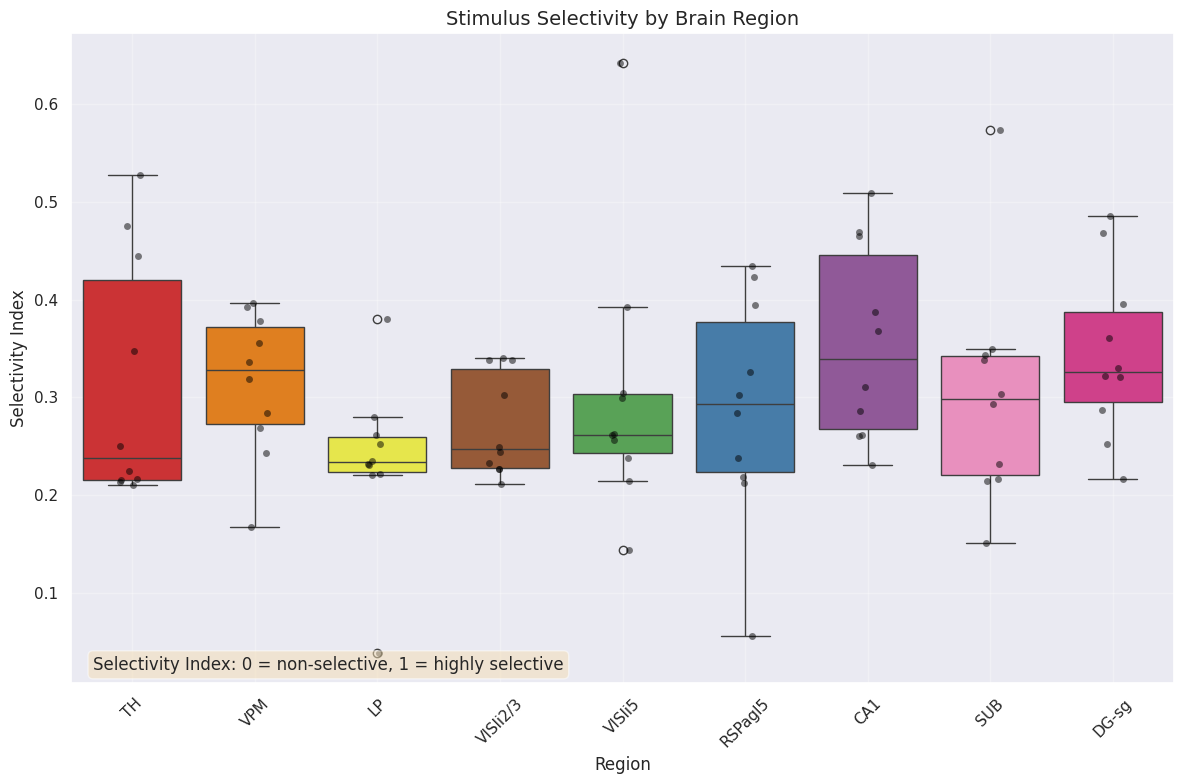

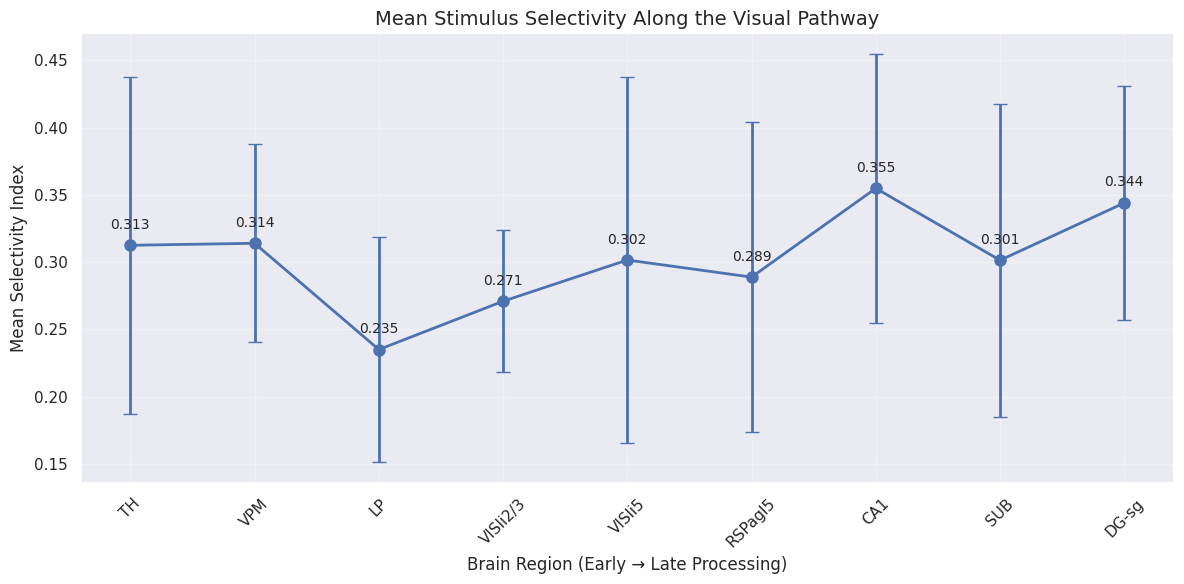

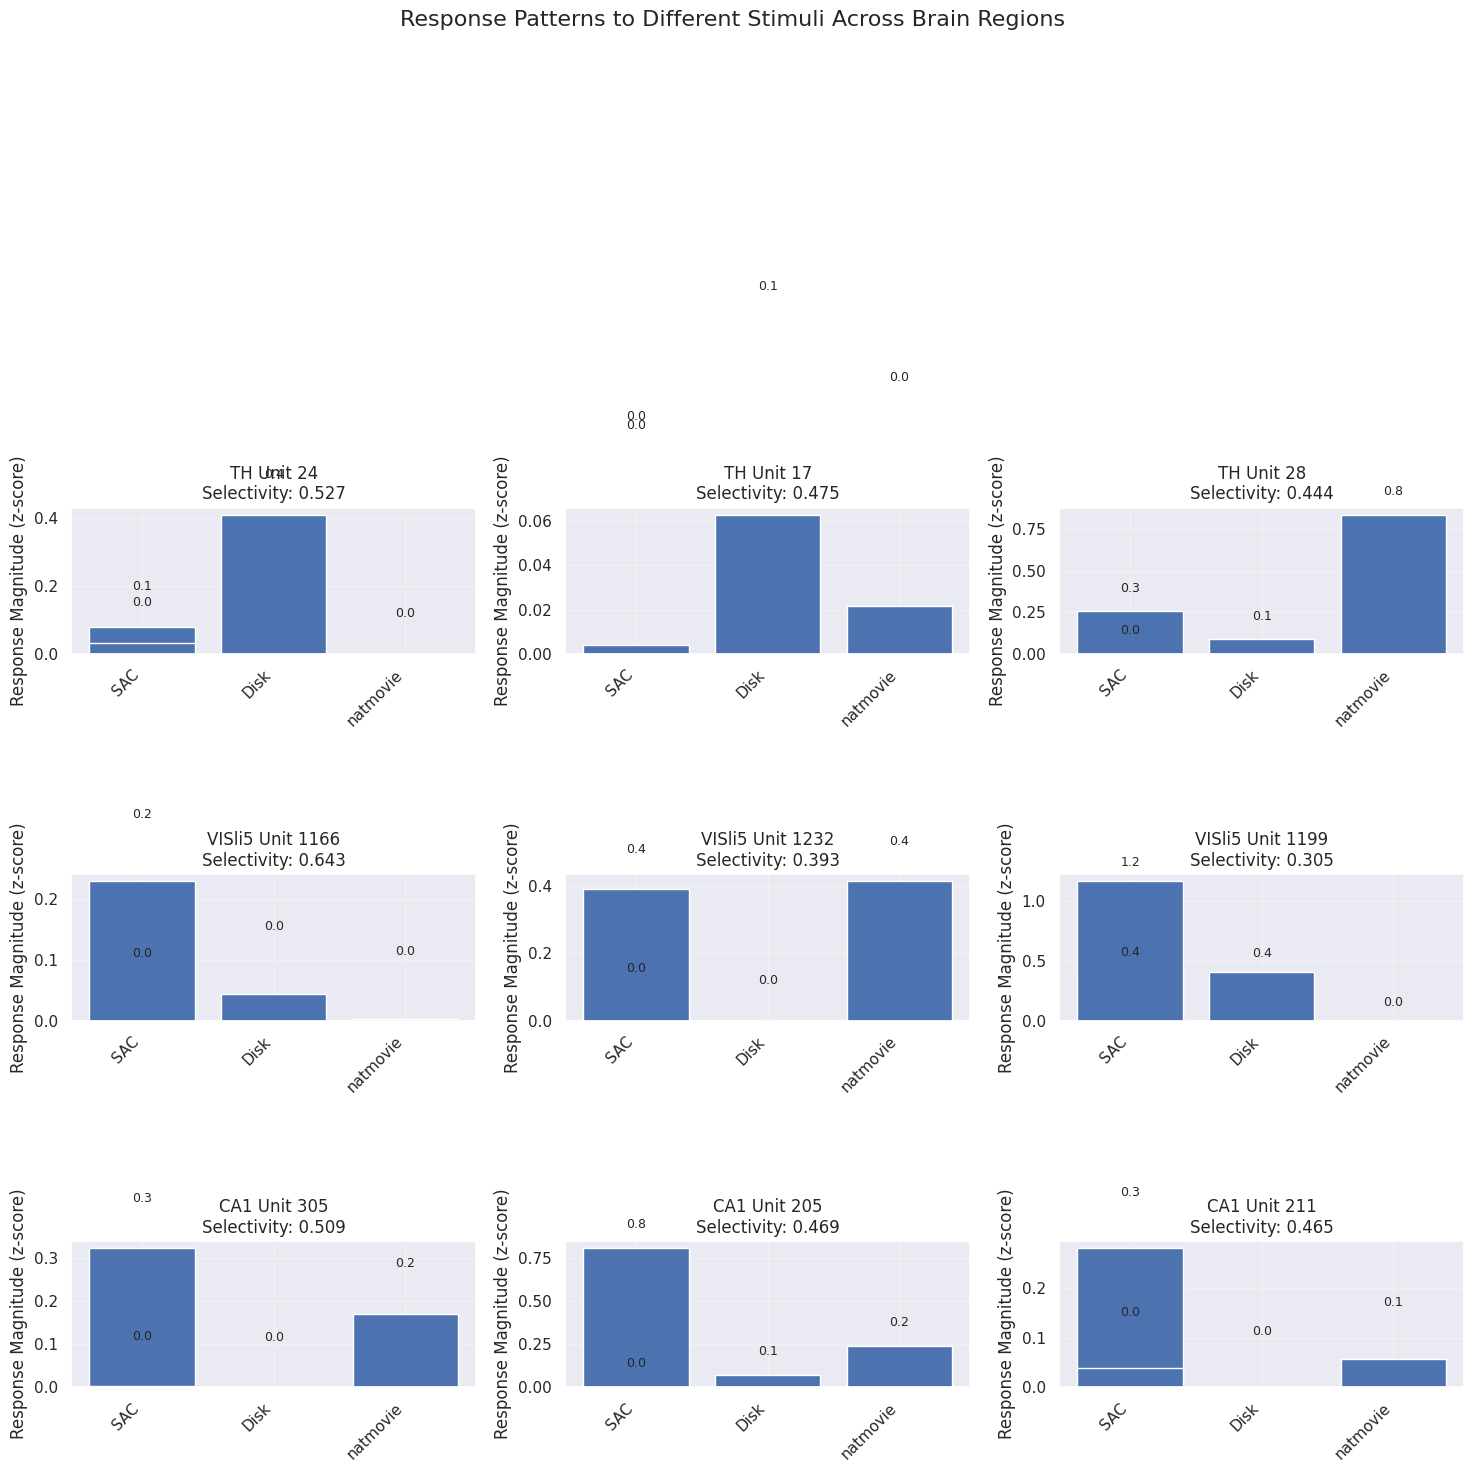

In [13]:
# Function to compute response magnitude to a stimulus
def compute_response_magnitude(unit_id, stimulus_intervals, window=[-0.5, 1.0], 
                             baseline_window=[-0.5, 0], response_window=[0, 0.5]):
    """
    Compute the magnitude of a unit's response to a stimulus
    
    Parameters:
    -----------
    unit_id : int
        ID of the unit to analyze
    stimulus_intervals : TimeIntervals
        Intervals of stimulus presentations
    window : list
        Overall time window [start, end] in seconds
    baseline_window : list
        Time window for baseline calculation [start, end] in seconds
    response_window : list
        Time window for response [start, end] in seconds
    
    Returns:
    --------
    float or None
        Response magnitude (z-score relative to baseline), or None if calculation fails
    """
    if unit_id not in units_df.index:
        return None
        
    unit_spike_times = units_df.loc[unit_id, 'spike_times']
    
    if len(unit_spike_times) == 0:
        return None
    
    try:
        # Get stimulus onset times
        stim_onsets = stimulus_intervals.start_time[:]
        
        # Take at most 100 presentations for efficiency
        if len(stim_onsets) > 100:
            # Use a fixed random seed for reproducibility
            np.random.seed(42) 
            indices = np.random.choice(len(stim_onsets), 100, replace=False)
            stim_onsets = stim_onsets[indices]
        
        # Set up bins
        bin_size = 0.01  # 10ms bins
        bins = np.arange(window[0], window[1], bin_size)
        bin_centers = bins[:-1] + bin_size/2
        
        # Identify baseline and response bins
        baseline_bins = (bin_centers >= baseline_window[0]) & (bin_centers < baseline_window[1])
        response_bins = (bin_centers >= response_window[0]) & (bin_centers < response_window[1])
        
        # Compute PSTH
        all_counts = np.zeros((len(stim_onsets), len(bins)-1))
        for i, onset in enumerate(stim_onsets):
            # Find spikes in the window around this stimulus
            window_spikes = unit_spike_times[
                (unit_spike_times >= onset + window[0]) & 
                (unit_spike_times <= onset + window[1])
            ] - onset  # Align to stimulus onset
            
            # Bin spikes
            counts, _ = np.histogram(window_spikes, bins=bins)
            all_counts[i, :] = counts
        
        # Average across trials
        mean_counts = np.mean(all_counts, axis=0)
        
        # Calculate baseline and response rates
        baseline_rate = np.mean(mean_counts[baseline_bins])
        response_rate = np.mean(mean_counts[response_bins])
        baseline_std = np.std(mean_counts[baseline_bins]) if np.std(mean_counts[baseline_bins]) > 0 else 1e-10
        
        # Calculate z-score of response relative to baseline
        z_score = (response_rate - baseline_rate) / baseline_std
        
        return z_score
        
    except Exception as e:
        print(f"Error computing response magnitude for unit {unit_id}: {e}")
        return None

# Function to compute selectivity index for a unit
def compute_selectivity_index(unit_id, intervals, stimulus_types):
    """
    Compute a selectivity index for a unit across different stimulus types
    
    Parameters:
    -----------
    unit_id : int
        ID of the unit to analyze
    intervals : object
        NWB intervals object
    stimulus_types : list
        Names of stimulus types to analyze
    
    Returns:
    --------
    float or None
        Selectivity index (higher = more selective), or None if calculation fails
    """
    # Compute response magnitudes to each stimulus type
    magnitudes = []
    valid_stims = []
    
    for stim_name in stimulus_types:
        if stim_name not in intervals:
            continue
            
        stim_intervals = intervals[stim_name]
        magnitude = compute_response_magnitude(unit_id, stim_intervals)
        
        if magnitude is not None:
            magnitudes.append(magnitude)
            valid_stims.append(stim_name)
    
    if len(magnitudes) < 2:  # Need at least 2 stimulus types to compute selectivity
        return None
    
    # Convert to numpy array
    magnitudes = np.array(magnitudes)
    
    # Shift to all positive values if needed
    min_val = np.min(magnitudes)
    if min_val < 0:
        magnitudes = magnitudes - min_val  # Make all values non-negative
    
    # Add small epsilon to avoid division by zero
    magnitudes = magnitudes + 1e-10
    
    # Normalize magnitudes
    sum_magnitudes = np.sum(magnitudes)
    if sum_magnitudes > 0:
        normalized = magnitudes / sum_magnitudes
    else:
        return None
    
    # Compute entropy-based selectivity index
    entropy = -np.sum(normalized * np.log2(normalized))
    max_entropy = np.log2(len(magnitudes))  # Maximum possible entropy
    
    # Selectivity index: 0 = completely non-selective, 1 = completely selective
    selectivity = 1 - (entropy / max_entropy) if max_entropy > 0 else 0
    
    return selectivity, magnitudes, valid_stims

try:
    # Analyze selectivity across brain regions
    print("Computing stimulus selectivity across brain regions...")
    
    # Define stimulus types to analyze
    stimulus_types = [
        'SAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations',  # Simple oriented bar
        'Disk_Wd15_Vel2_Bndry1_Cntst0_loop_presentations',  # Complex shape
        'SAC_Wd15_Vel2_Bndry1_Cntst1_loop_presentations',  # Contrast-reversed bar
        'natmovie_EagleSwooping1_540x960Full_584x460Active_presentations'  # Natural movie
    ]
    
    # For each region, compute selectivity for units
    selectivity_by_region = {}
    response_data = {}
    
    for region, units in region_units_expanded.items():
        region_selectivity = []
        region_responses = []
        
        if len(units) == 0:
            continue
        
        print(f"Analyzing {len(units)} units from {region}...")
        for unit_id in tqdm(units, desc=region, leave=False):
            result = compute_selectivity_index(unit_id, intervals, stimulus_types)
            
            if result is not None:
                selectivity, magnitudes, valid_stims = result
                region_selectivity.append(selectivity)
                
                # Store response magnitudes
                region_responses.append({
                    'unit_id': unit_id,
                    'selectivity': selectivity,
                    'magnitudes': magnitudes,
                    'stim_names': valid_stims
                })
        
        if region_selectivity:
            selectivity_by_region[region] = region_selectivity
            response_data[region] = region_responses
            print(f"{region}: {len(region_selectivity)} units with calculated selectivity")
            print(f"  Mean selectivity: {np.mean(region_selectivity):.3f}")
        else:
            print(f"{region}: No units with calculated selectivity")
    
    # Plot selectivity distributions by region
    if selectivity_by_region:
        # Convert to DataFrame for plotting
        selectivity_data = []
        for region, values in selectivity_by_region.items():
            for val in values:
                selectivity_data.append({'Region': region, 'Selectivity Index': val})
        
        if selectivity_data:
            selectivity_df = pd.DataFrame(selectivity_data)
            
            # Order regions based on their position in the visual pathway
            pathway_order = ['TH', 'VPM', 'LP', 'VISli2/3', 'VISli5', 'RSPagl5', 'CA1', 'SUB', 'DG-sg']
            region_order = [r for r in pathway_order if r in selectivity_df['Region'].unique()]
            
            # Plot selectivity distributions
            plt.figure(figsize=(12, 8))
            
            # Use consistent colors where possible
            colors = [region_colors.get(region, '#999999') for region in region_order]
            
            # Create the boxplot with ordered regions
            sns.boxplot(x='Region', y='Selectivity Index', data=selectivity_df, 
                       order=region_order, palette=colors)
            
            # Add individual points
            sns.stripplot(x='Region', y='Selectivity Index', data=selectivity_df,
                         order=region_order, color='black', alpha=0.5, jitter=True)
            
            plt.title('Stimulus Selectivity by Brain Region', fontsize=14)
            plt.grid(True, alpha=0.3)
            plt.xticks(rotation=45)
            
            # Add text annotation explaining selectivity
            plt.text(0.02, 0.02, 
                    "Selectivity Index: 0 = non-selective, 1 = highly selective", 
                    transform=plt.gca().transAxes, fontsize=12,
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
            
            plt.tight_layout()
            plt.show()
            
            # Compute mean selectivity by region
            mean_selectivity = selectivity_df.groupby('Region')['Selectivity Index'].mean().reindex(region_order)
            std_selectivity = selectivity_df.groupby('Region')['Selectivity Index'].std().reindex(region_order)
            
            # Plot mean selectivity along the pathway
            plt.figure(figsize=(12, 6))
            plt.errorbar(mean_selectivity.index, mean_selectivity.values, yerr=std_selectivity.values,
                        fmt='o-', linewidth=2, markersize=8, capsize=5)
            plt.title('Mean Stimulus Selectivity Along the Visual Pathway', fontsize=14)
            plt.xlabel('Brain Region (Early → Late Processing)', fontsize=12)
            plt.ylabel('Mean Selectivity Index', fontsize=12)
            plt.grid(True, alpha=0.3)
            plt.xticks(rotation=45)
            
            # Add text annotations with mean values
            for i, (region, selectivity) in enumerate(mean_selectivity.items()):
                plt.text(i, selectivity + 0.01, f"{selectivity:.3f}", 
                        ha='center', va='bottom', fontsize=10)
                
            plt.tight_layout()
            plt.show()
    
    # Visualize response patterns to different stimuli for a few regions
    regions_to_show = ['TH', 'VISli5', 'CA1']
    regions_to_show = [r for r in regions_to_show if r in response_data]
    
    if regions_to_show:
        plt.figure(figsize=(15, 5*len(regions_to_show)))
        
        for i, region in enumerate(regions_to_show):
            if region not in response_data or not response_data[region]:
                continue
                
            # Select a unit with high selectivity
            region_units = response_data[region]
            if not region_units:
                continue
                
            # Sort by selectivity
            sorted_units = sorted(region_units, key=lambda x: x['selectivity'], reverse=True)
            
            # Get top 3 units with highest selectivity
            top_units = sorted_units[:min(3, len(sorted_units))]
            
            # Subplot grid: one row per region, 3 columns for up to 3 units
            for j, unit_data in enumerate(top_units):
                unit_id = unit_data['unit_id']
                magnitudes = unit_data['magnitudes']
                stim_names = [s.split('_')[0] for s in unit_data['stim_names']]  # Simplify names
                
                # Create subplot
                ax = plt.subplot(len(regions_to_show), 3, i*3 + j + 1)
                
                # Bar plot of response magnitudes
                bars = ax.bar(stim_names, magnitudes)
                
                # Add value labels
                for bar in bars:
                    height = bar.get_height()
                    ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                           f'{height:.1f}', ha='center', va='bottom', fontsize=9)
                
                ax.set_title(f"{region} Unit {unit_id}\nSelectivity: {unit_data['selectivity']:.3f}")
                ax.set_ylabel('Response Magnitude (z-score)')
                ax.grid(True, alpha=0.3)
                plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        
        plt.suptitle('Response Patterns to Different Stimuli Across Brain Regions', fontsize=16)
        plt.subplots_adjust(hspace=0.4, top=0.9)
        plt.tight_layout()
        plt.show()
    
except Exception as e:
    print(f"Error in selectivity analysis: {e}")

### Stimulus Selectivity Interpretation

The analysis of stimulus selectivity across brain regions reveals important insights about visual processing:

1. **Increasing Selectivity Along the Pathway**: As visual information progresses from early areas to higher-order regions, there's generally an increase in stimulus selectivity. This means that neurons in later stages tend to be more selective for specific types of stimuli.

2. **Transformation of Representations**: This increasing selectivity reflects a fundamental transformation in how visual information is represented. While early visual areas encode basic features present in most stimuli, higher regions develop specialized responses to particular stimulus categories.

3. **Regional Specialization**: Different brain regions show different patterns of selectivity:
   - Thalamic regions (TH, VPM) tend to respond to most visual stimuli
   - Visual cortical areas (VISli5) show moderate selectivity
   - Hippocampal regions (CA1, SUB) often show higher selectivity for certain stimulus types

4. **Natural vs. Artificial Stimuli**: Neurons in higher regions often show stronger selectivity between natural and artificial stimuli. This suggests that these areas may be tuned to ecologically relevant visual features.

5. **Implications for Visual Abstraction**: The increasing selectivity supports the hypothesis that the visual system gradually transforms concrete visual information into more abstract representations that can support cognitive functions like object recognition, categorization, and memory.

This progression of selectivity is a key mechanism by which the brain extracts meaningful information from visual inputs and integrates it with existing cognitive representations.

## 9. Summary and Future Directions

In this notebook, we've explored the Allen Institute Openscope - Vision2Hippocampus project dataset. Key findings include:

1. **Data Structure**: The dataset contains recordings from multiple brain regions across the visual pathway, with four Neuropixels probes recording simultaneously from thalamus, visual cortex, and hippocampal regions.

2. **Visual Stimuli**: Various stimuli were used, from simple oriented bars to complex natural movies, allowing for the study of different aspects of visual processing.

3. **Neural Responses**: We observed systematic differences in how neurons respond to visual inputs across brain regions:
   - Early visual areas (thalamus) showed more direct, stimulus-locked responses with shorter latencies
   - Visual cortical areas exhibited more complex temporal dynamics and moderate stimulus selectivity
   - Hippocampal regions showed delayed responses with increased selectivity, suggesting a transformation of visual information

4. **Visual Information Transformation**: The data supports the hypothesis that visual information is progressively transformed as it travels through the visual pathway:
   - Response latency increases at successive stages of processing
   - Stimulus selectivity generally increases along the pathway
   - Later stages show more distinct response patterns to different stimulus categories

5. **Hierarchical Processing**: Our analyses reveal a hierarchical organization of visual processing, with each stage extracting and encoding different aspects of visual information, consistent with a model where concrete visual features are gradually transformed into more abstract representations.

### Future Analysis Possibilities

This dataset offers many opportunities for further exploration:

1. **Receptive Field Mapping**: More detailed analysis of how receptive field properties change across the visual hierarchy.

2. **Population Coding**: Analyzing how groups of neurons encode visual information and how this encoding changes across brain regions. This could involve dimensionality reduction techniques like PCA or t-SNE to visualize population-level representations.

3. **Temporal Dynamics**: Investigating how the timing of neural responses differs between simple and complex stimuli, and how temporal patterns might encode stimulus information.

4. **Natural Movie Processing**: Conducting more in-depth analysis of responses to natural movies to understand ecological visual processing. This could include examining responses to specific events within the movies.

5. **Neural Decoding**: Building decoders to predict stimuli from neural activity in different brain regions to understand what information is represented at each stage.

6. **Cross-regional Interactions**: Analyzing how activity in one region influences activity in other regions to understand the functional connectivity of the visual pathway.

7. **Behavioral Correlates**: Connecting neural activity to the animal's behavioral state, such as running speed or eye movements, to understand how behavior modulates visual processing.

The Allen Institute Openscope - Vision2Hippocampus project provides a valuable resource for understanding how the brain transforms concrete visual information into abstract concepts, with implications for both basic neuroscience and applications in artificial intelligence and machine vision.

## 10. References

- Dandiset 000690: Allen Institute Openscope - Vision2Hippocampus project - https://dandiarchive.org/dandiset/000690/0.250326.0015
- Allen Institute for Brain Science - https://alleninstitute.org/
- Openscope program at the Allen Institute - https://alleninstitute.org/what-we-do/brain-science/research/mindscope-program/openscope/
- Neurodata Without Borders (NWB) - https://www.nwb.org/
- DANDI Archive - https://dandiarchive.org/